# Investigating perplexity scores for promoter regions using varying promoter extraction techniques
For my NLP class final project, I used a count-based Language Modeling technique to investigate the perplexity across various "corpora" of promoters. The idea was to see if language modeling could indeed capture some amount of the sequence patterns that exist DNA regulatory sequences. Here I focus on _E. coli_ sequences but would eventually like to analyze a the less well-studied _Methylomicrobium buryatense_, a methane-eating bacteria. 

This notebook is a bit of an exploratory start and was used for the analysis of my class project. Perhaps it will be extended in the future!

See Final Report PDF for further discussion of the project results.

In [1]:
import Bio
from Bio import SeqIO, SeqFeature
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import random; random.seed(0)
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')


## Genbank files and general genome info

In [2]:
# 5GB1c genome (Methylomicrobium buryatense from Mitch)
gbFile_5G = 'data/5GB1c.current.gb'

# E. coli genome (https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.2)
gbFile_ecoli = 'data/ecoli_k12_NC_000913.2.gb'

In [3]:
gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()
gb_ecoli = SeqIO.parse(gbFile_ecoli, "genbank").__next__()

print("___ 5G ____")
print("Genome length:", len(gb_5G.seq), "bps")
print("num features:", len(gb_5G.features))
print("num CDS features:", len([x for x in gb_5G.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_5G.features if x.type=='gene']))

print("\n___ Ecoli ____")
print("Genome length:", len(gb_ecoli.seq), "bps")
print("num features:", len(gb_ecoli.features))
print("num CDS features:", len([x for x in gb_ecoli.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_ecoli.features if x.type=='gene']))

___ 5G ____
Genome length: 4998879 bps
num features: 8863
num CDS features: 4369
num gene features: 4427

___ Ecoli ____
Genome length: 4639675 bps
num features: 9913
num CDS features: 4321
num gene features: 4497


In [4]:
# a sampling of genbank features
for x in gb_5G.features[:5]:
    print(x)
    
for x in gb_ecoli.features[:5]:
    print(x)

type: source
location: [0:4998879](+)
qualifiers:
    Key: collection_date, Value: ['1999-01']
    Key: country, Value: ['Russia: Transbaikal']
    Key: db_xref, Value: ['taxon:95641']
    Key: isolation_source, Value: ['Soda lake sediment']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Methylomicrobium buryatense']
    Key: strain, Value: ['5GB1C']

type: gene
location: [0:1317](+)
qualifiers:
    Key: gene, Value: ['dnaA']
    Key: locus_tag, Value: ['EQU24_00005']

type: CDS
location: [0:1317](+)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: gene, Value: ['dnaA']
    Key: inference, Value: ['COORDINATES: similar to AA sequence:RefSeq:WP_006891211.1']
    Key: locus_tag, Value: ['EQU24_00005']
    Key: note, Value: ['Derived by automated computational analysis using gene prediction method: Protein Homology.']
    Key: product, Value: ['chromosomal replication initiator protein DnaA']
    Key: protein_id, Value: ['PRJNA515283:EQU24_00005']
    Key: tr

## CDS processing
With the genbank files properly loaded and the features accessible, extract out all the Coding Sequence (CDS) features from the genome (use their start and end coordinates to slice out the appropriate genome sequence)

In [5]:
def get_cds_coords(seq_record):
    '''
    Given a SeqRecord parsed from a genbank file, return a list of 
    all the CDS start/end coordinates and gene/locus names
    '''
    cds_list = []
    # Loop over the genome CDS features on each of the strands
    for feature in seq_record.features:
        if feature.type == 'CDS':
            # get  locus tag and gene name
            lt = feature.qualifiers['locus_tag'][0]
            g = "" if 'gene' not in feature.qualifiers else feature.qualifiers['gene'][0]
            
            cds_list.append((feature.location.start.position,
                             feature.location.end.position,
                             feature.strand,
                             lt,
                             g))
    return cds_list

In [6]:
cds_5G = get_cds_coords(gb_5G)
print("First few 5G genes")
print(cds_5G[:10])
print()

cds_ecoli = get_cds_coords(gb_ecoli)
print("First few E coli genes")
print(cds_ecoli[:10])

First few 5G genes
[(0, 1317, 1, 'EQU24_00005', 'dnaA'), (1502, 2603, 1, 'EQU24_00010', ''), (3060, 4140, 1, 'EQU24_00015', 'recF'), (4185, 6600, 1, 'EQU24_00020', 'gyrB'), (6825, 7062, 1, 'EQU24_00025', ''), (7098, 7257, 1, 'EQU24_00030', ''), (7350, 7734, 1, 'EQU24_00035', ''), (7818, 9075, 1, 'EQU24_00040', ''), (9071, 10241, 1, 'EQU24_00045', ''), (10240, 13306, 1, 'EQU24_00050', '')]

First few E coli genes
[(189, 255, 1, 'b0001', 'thrL'), (336, 2799, 1, 'b0002', 'thrA'), (2800, 3733, 1, 'b0003', 'thrB'), (3733, 5020, 1, 'b0004', 'thrC'), (5233, 5530, 1, 'b0005', 'yaaX'), (5682, 6459, -1, 'b0006', 'yaaA'), (6528, 7959, -1, 'b0007', 'yaaJ'), (8237, 9191, 1, 'b0008', 'talB'), (9305, 9893, 1, 'b0009', 'mog'), (9927, 10494, -1, 'b0010', 'yaaH')]


### Check that all the features in the CDS lists are indeed ordered

In [7]:
# 5G start coordinates and genome locus tags
starts = [x[0] for x in cds_5G]
print(starts == sorted(starts))
loci = [x[3].split('_')[1] for x in cds_5G]
print(loci == sorted(loci))

print()

# E coli start coordinates and genome locus tags
starts = [x[0] for x in cds_ecoli]
print(starts == sorted(starts))
loci = [x[3][1:] for x in cds_ecoli]
print(loci == sorted(loci))

True
True

True
False


In [8]:
# Seems like some ecoli genes were added between others after the fact (like hokC)... 
# probs ok...?
cds_ecoli[:20]

[(189, 255, 1, 'b0001', 'thrL'),
 (336, 2799, 1, 'b0002', 'thrA'),
 (2800, 3733, 1, 'b0003', 'thrB'),
 (3733, 5020, 1, 'b0004', 'thrC'),
 (5233, 5530, 1, 'b0005', 'yaaX'),
 (5682, 6459, -1, 'b0006', 'yaaA'),
 (6528, 7959, -1, 'b0007', 'yaaJ'),
 (8237, 9191, 1, 'b0008', 'talB'),
 (9305, 9893, 1, 'b0009', 'mog'),
 (9927, 10494, -1, 'b0010', 'yaaH'),
 (10642, 11356, -1, 'b0011', 'yaaW'),
 (11381, 11786, -1, 'b0013', 'yaaI'),
 (12162, 14079, 1, 'b0014', 'dnaK'),
 (14167, 15298, 1, 'b0015', 'dnaJ'),
 (15444, 16557, 1, 'b0016', 'insL1'),
 (16750, 16960, -1, 'b0018', 'mokC'),
 (16750, 16903, -1, 'b4412', 'hokC'),
 (17488, 18655, 1, 'b0019', 'nhaA'),
 (18714, 19620, 1, 'b0020', 'nhaR'),
 (19810, 20314, -1, 'b0021', 'insB1')]

### Quick plots to see distribution of CDS lengths
Just some sanity checking that these genes seem reasonable. Also, comparing patterns from _E. coli_ vs _M. buryatense_

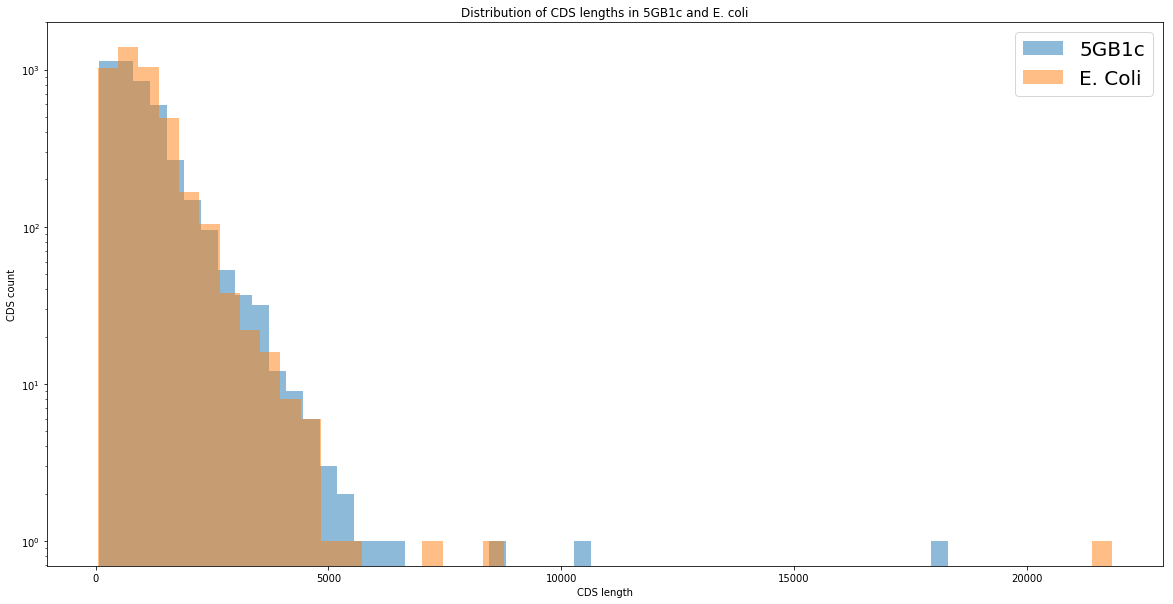

In [9]:
# get CDS lengths by subtracting the start coord from the end coord
cds_5G_lengths = [e-s for (s,e,_,_,_) in cds_5G]
cds_ecoli_lengths = [e-s for (s,e,_,_,_) in cds_ecoli]

# plotting, use log scale
plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=50, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=50, label='E. Coli')
plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli")
plt.legend(fontsize = 20)
plt.show()

### Same data, zoomed in, no log scale

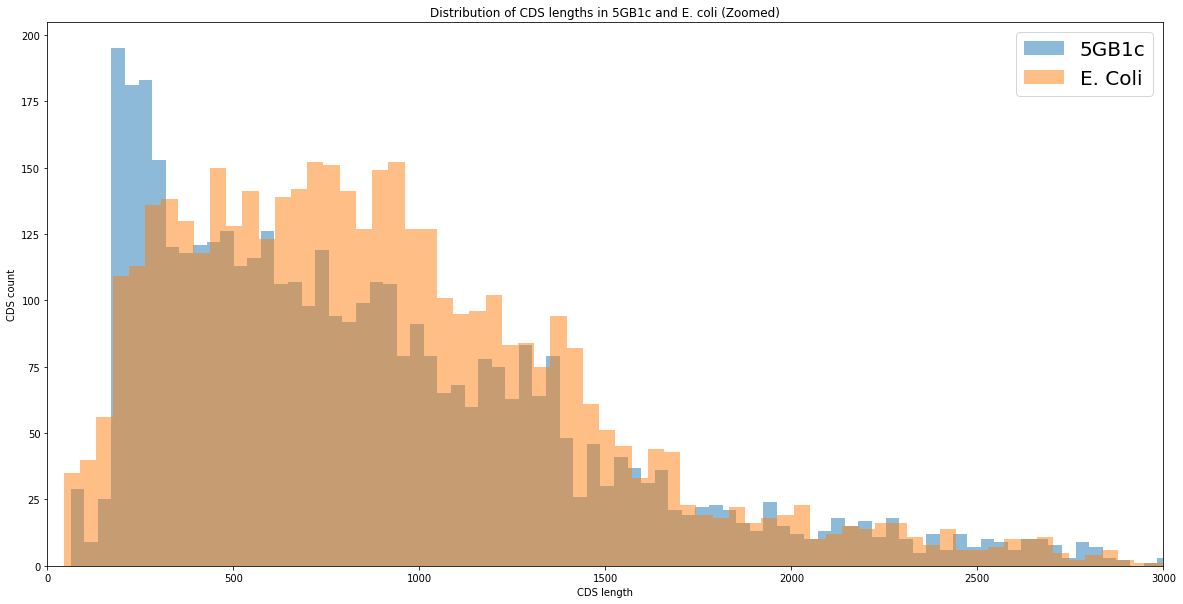

In [10]:
plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=500, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=500, label='E. Coli')

#plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli (Zoomed)")
plt.xlim(0,3000)
plt.legend(fontsize = 20)
plt.show()

### Gene locus look up dictionaries
For convenience, make a couple lookup tables mapping the genome locus name to the common gene name and vice versa

In [11]:
def get_locus_gene_lookup(cds_list):
    '''
    Given a list of CDSs with locus tag and gene info, return a dict mapping
    locus tag to gene name
    '''
    locus_gene_lookup = {}
    gene_locus_lookup = {}
    # loop through the CDS list and make a look up of locus to gene
    for x in cds_list:
        if x[4]== '':
            # if the gene name is empty, just use the locus tag
            locus_gene_lookup[x[3]] = x[3]
        # otherwise use the gene name
        else:
            locus_gene_lookup[x[3]] = x[4]
            gene_locus_lookup[x[4]] = x[3]

    return locus_gene_lookup, gene_locus_lookup

locus_gene_lookup_5G, gene_locus_lookup_5G = get_locus_gene_lookup(cds_5G)
locus_gene_lookup_ecoli, gene_locus_lookup_ecoli = get_locus_gene_lookup(cds_ecoli)



# Promoter Extraction
After sorting through all the genes/CDS features, now I look upstream of the gene start coordinate for the actual promoter sequences. However in bacteria, we need to lookout for Operons, clusters of genes that actually share the same promoter and get transcribed together. 

The ```get_promoters()``` function has a few options to customize how to extract promoters sequences and allows you to ignore genes that are too close to each other (likely in operons). This is not a formal operon finding tool, just a quick-n-dirty way to try to get a _better_ set of promoter examples than the naive way of just getting all upstream sequences of all genes. Comparing naive and operon-conscious corpora of promoters should ideally yield some differences in perplexity (the Naive set would have much more noise in the input and overall be "more perplexing" to a language model)

In [12]:
def get_promoters(gb_record, 
                  cds_list, 
                  promoter_window = 300,
                  operon_mode = False, 
                  min_gene_distance=40):
    '''
    Given a list of CDSs with (LEFT, RIGHT, STRAND, locus, gene),
    loop through and collect their promoters by getting the 300 bp
    upstream of the start codon. If in operon conscious mode, ignore 
    regions that fall within min_gene_distance bp of another gene. 
    (Won't exhaustively consider all operons but a quick-n-dirty start)
    
    Args:
      * promoter_window: how far upstream of a gene should we extract a promoter region?
      * operon_mode: When True, it will ignore upstream regions which are "too close" to the 
          current gene (aka within min_gene_distance of the start codon)
      * min_gene_distance: min distance required between the current gene and its 
          upstream neighbor otherwise we flag it as a potential operon
    '''
    promoters = [] # promoter sequence and genes they belong to
    candidate_operon_genes = [] # gene pairings that are potentially in the same operon
    operon_locs = [] # mid point in intergenic distance between two genes which have been 
                     # flagged as potentially in an operon
    
    # loop through all CDSs
    for i,(g_left,g_right,strand,locus,gene) in enumerate(cds_list):
        # keep track of whether or not to skip operon
        operon_skip_flag = False
        
        gene_string = "%s|%s" % (locus, gene)
        
        # +-----------------+
        # | NEGATIVE STRAND |
        # +-----------------+
        # if we're on the negative strand, go 300bp to the right, reverse compelement
        if strand == -1:
            # get the range of the promoter region
            p_left = g_right + 1
            p_right = p_left + promoter_window
            
            # extract actual DNA
            seq = gb_record.seq[p_left:p_right]
            
            # if we're in operon mode and this isn't the last gene (aka no rightward operon),
            # check the min_distance window for other annotations
            if operon_mode and i < len(cds_list) -1:
                # get the FOLLOWING feature (because on -1 strand)
                upstream_gene = cds_list[i+1]
                # if the left side of the upstream gene is within min_distance
                if (
                    upstream_gene[0] < (g_right + min_gene_distance) and
                    upstream_gene[2] == strand # and same strand 
                ): 
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_right + upstream_gene[0])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))

        # +-----------------+
        # | POSITIVE STRAND |
        # +-----------------+
        # if we're on the positive strand, go 300bp to the left
        else:
            # get the range of the promoter region
            p_right = g_left - 1 
            p_left = p_right - promoter_window
            
            # if we run off the edge of the genome, ignore for now
            if p_left < 0:
                #print(gene, p_left)
                seq = ''
            else:
                # extract actual DNA
                seq = gb_record.seq[p_left:p_right].reverse_complement()
            
            # if we're in operon mode and this isn't the first gene (aka no leftward operon),
            # check this window for other annotations
            if operon_mode and i != 0:
                # get the PREVIOUS feature (because on +1 strand)
                upstream_gene = cds_list[i-1]
                # if the right side of the upstream gene is within min_distance
                if (
                    upstream_gene[1] > (g_left - min_gene_distance) and 
                    upstream_gene[2] == strand # and same strand
                ):
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_left + upstream_gene[1])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))
        
        # To skip or NOT to skip?
        if not operon_skip_flag and seq != '':
            promoters.append((gene_string, str(seq)))
            
    return promoters, operon_locs, candidate_operon_genes
        
        

In [13]:
# 5G
print("5G")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_5G,_,_ = get_promoters(gb_5G,cds_5G)
print("Num naive promoters:", len(naive_p_set_5G))

# use operon-conscious strategy to extract promoters
operon_p_set_5G, operon_locs_5G, op_cand_5G = get_promoters(gb_5G, cds_5G, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_5G))
print()

# Ecoli
print("E. Coli")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_ecoli,_,_ = get_promoters(gb_ecoli,cds_ecoli)
print("Num naive promoters:", len(naive_p_set_ecoli))

# use operon-conscious strategy to extract promoters
operon_p_set_ecoli, operon_locs_ecoli, op_cand_ecoli = get_promoters(gb_ecoli, cds_ecoli, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_ecoli))


5G
Num naive promoters: 4368
Num operon promoters: 2839

E. Coli
Num naive promoters: 4320
Num operon promoters: 2818


In [14]:
print(naive_p_set_5G[:6])
print()
print(operon_p_set_5G[:6])
# ^^ Sanity check: operon_p_set has decided to skip EQU24_00030!

[('EQU24_00010|', 'TAAGATATTTATTTATATTTACTATTAGCCTATAAAAAAAGCGTGATAAGTCATTTTTTATTTTATTTATCAATAGCTTATGAACTGTAAAACCGGCGTTTAAAGCTGTGGATAAGCGCTTGATAAAAAGAGGATAACTCTCCTTCTCTGCTAAAGACTATAGTTATCCACAAGTTAAACACCGTTAATGCGACAATGTTCTCAACAGGTTTAAATAATCTTCCTCAAGCTTTACATCCGAATCACGTAAAGAAGCAATGCGTTTACAAGCATTAATAACCGTGGTGTGATCGCGTCCAC'), ('EQU24_00015|recF', 'GTTTATTAGTTGCTAGTCAAAAAAAGCACGCGGTTAACACCGGTTAGATGAACAACAAGCTCGTTTTTTTGTTGCTTCCACATTTAATAATGACTGCGATTTAGAAATTTCAGGAAGTTAGTGAAAAGTTGACCTTAACGTTCATGAAAGCCAGGTCATCGCCCCGGAAAATGAAAGCTCTGGGTAGCTGAGGGTGCGGTCACTCGACCGACAGGACACCGTGAATACGTCCGTGTAGGCTTGACGGCGGCTATCCTTGCCGCCGACGCCTGTCGGACGAGAAACCGCCCCTCTTCGCAA'), ('EQU24_00020|gyrB', 'TGTGTTCACTACCTTCTCAATGTACCAATGTTTCACGTGAAACATTACGCTTGTTTAATTTCACCATGTTCCACGTGGAACATTTTATAGTTATTAAGTTTACTCAAATCACCATACTCAGACAGCTCAGTGGCCGTGATAAAAACCTGAACATCCATTGCTTGTAAATATTCTATTAACAGCGCTCTTTTGGTTGTATCCAATTCAGCAGTAAAATCATCGATTAAAACACAGACATTGTTACTCTGATGTGTCGACAATAATTGTACTTGCGCAAGCTTTAAACATAGAACTAACAAT'), ('EQU24_00025|', 'GCTCTTC

### Some sanity check plotting to see if what I'm calling possible operons looks reasonable

In [15]:
# get the genome coordinates as the x-axis, use the strand as the y axis
cds_strand_temp_5G = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_5G)]
cds_strand_temp_ecoli = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_ecoli)]

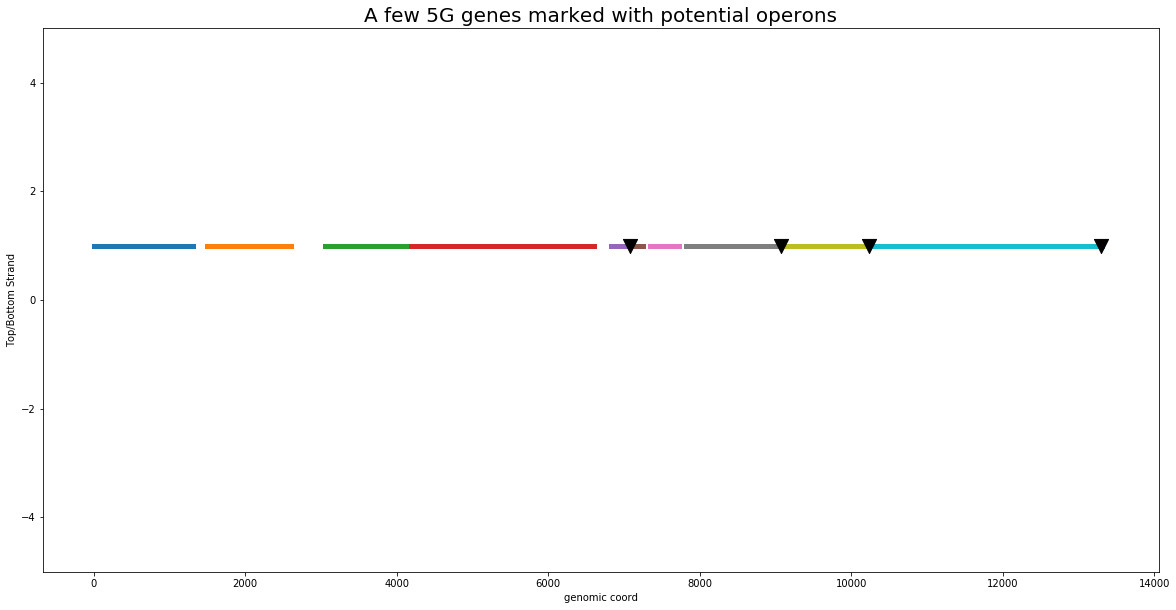

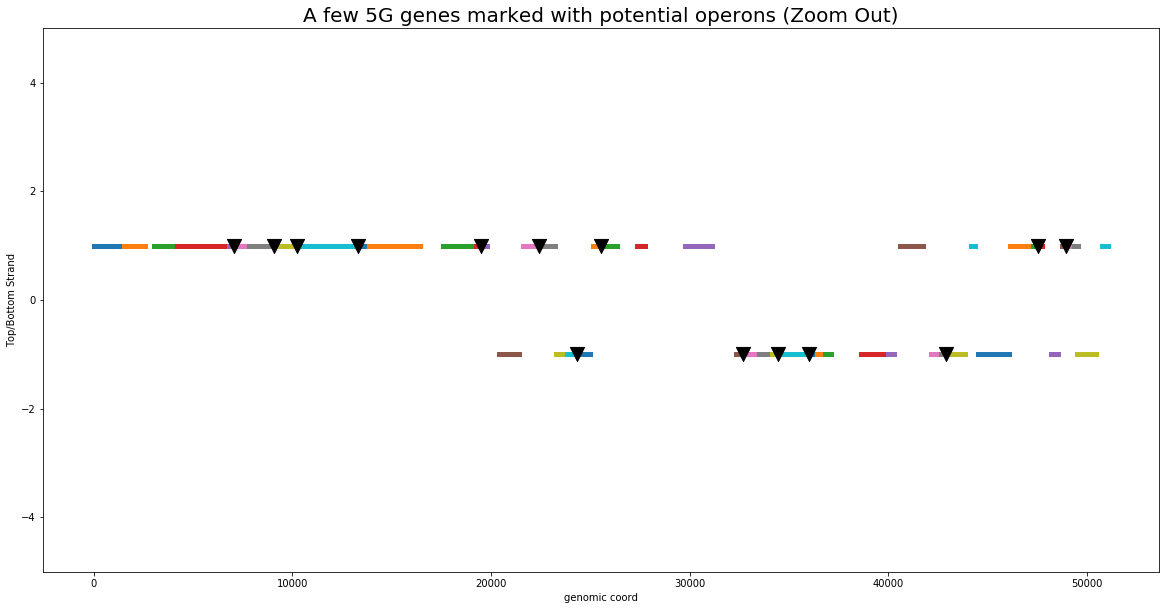

In [16]:
# plot the first few genes along the 5G genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:10]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:14]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

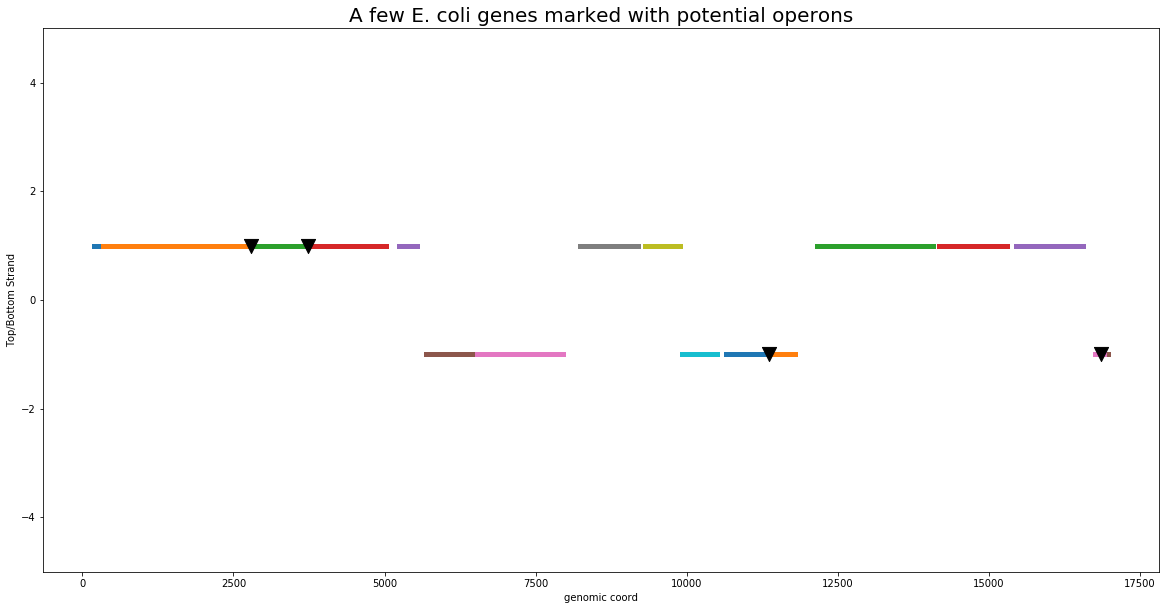

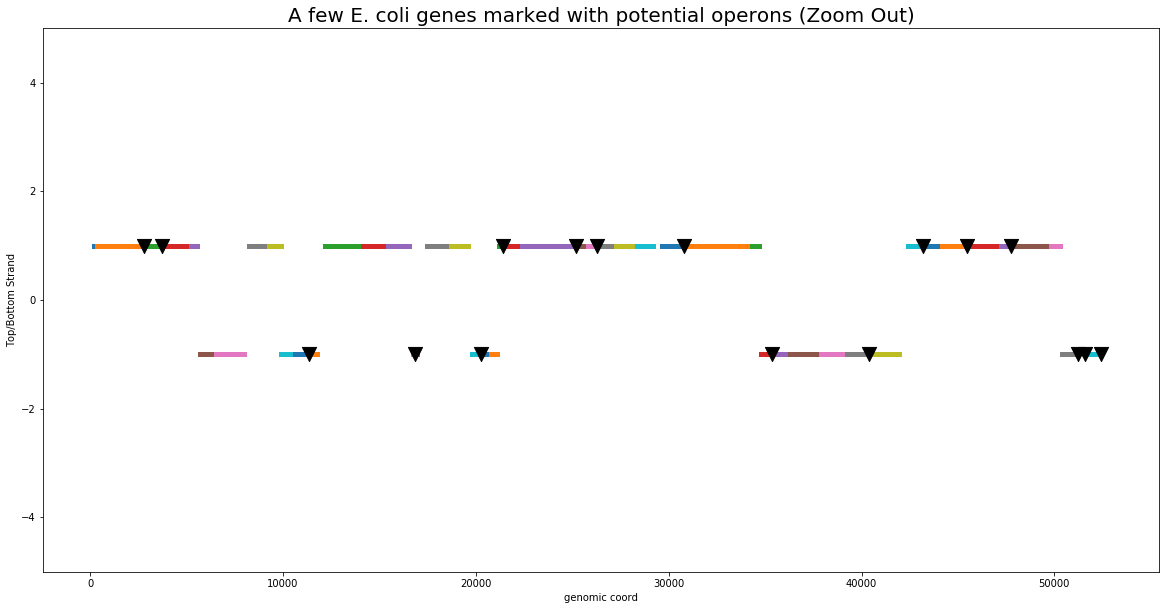

In [17]:
# plot the first few genes along the Ecoli genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:17]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:17]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

### Make some truly random "promoter sets"
Take random 300 bp sections from the genome and scramble them. These will be used to compare promoter perplexity to that of random sequences and confirm that the language model isn't accidentally picking up significant patterns where it shouldn't be

In [18]:
def generate_randomized_seqs(seq_record, name, k, promoter_window=300):
    '''
    Given a SeqRecord from genbank, generate k random sequences by extracting
    windows of size promoter_window then shuffling the sequence. The shuffling should 
    prevent us accidentally slicing out a actual promoter region but the fact that its
    not generated purely by an RNG means that the general frequency of bases should be
    preserved. 
    '''
    rand_seqs = []
    genome_length = len(seq_record.seq)
    
    # for as many promoters as we want to generate:
    for i in range(k):
        seq_name = "%s_RANDOM_%i" % (name, i)
        # pick a random location in the genome (not too close to the end)
        rand_loc = random.randint(0,genome_length-promoter_window)

        # get the sequence in that location
        seq = str(seq_record.seq[rand_loc:rand_loc+promoter_window])
        
        # shuffle the sequence
        rand_seq = ''.join(random.sample(seq,len(seq)))
        rand_seqs.append((seq_name,rand_seq))
        
    return rand_seqs

In [19]:
rand_proms_5G = generate_randomized_seqs(gb_5G,"5G", 4000)
rand_proms_ecoli = generate_randomized_seqs(gb_ecoli,"ECOLI", 4000)

In [20]:
rand_proms_5G[:5]
rand_proms_ecoli[:5]

[('ECOLI_RANDOM_0',
  'TTTAGCTTGCCGGGAGTACCTTCATTGCTTGTACCGGCTACAGTGTGGTCATGTCTAATAAAATCGCCCTGTACCCACGCGGCGCGGCAGCTAAAGTCGATATATCGAAGACCAAGCGTAGCAACTTGCTTGGGGTGAAGCAATGCGTACCCCCATTAGTTCGTTAAGCTTCTAATTTCCGTCATTCAGCCGTGGGCACGCGTCGAGAGATCAAATGTGGAATCATATCTACACCCATTTCGGATTCATGGGTGGATTAACGGTGCAATTACGTAGTCTAGGTATTTTTCGCGCGTCAGA'),
 ('ECOLI_RANDOM_1',
  'GCGTAAGGGACGGATATTTGGCGAGCAAAAGATAGATTGAGTAAGACAAAACAGAGTAATGTACCTCTATGTCCGTCCAGGGGTACAACCCGTACTCGATTCTTCCAGCTGCCTCACTGGTCTGCCAAACATTCTAATGGTAGCTGCTAGCTTTAATTAGAACCCAGCGACGGGGAAATTCACGTAGAGCCTTCTATCAGTGCGGGCTCCGGTGTGGACTCCGCTGTCAAACGACTGGCTCCTGCCCCATCCTGGCGCGAACCCTGACTCTAAAGCAGACATTTGTAAAGGTATCGTAAA'),
 ('ECOLI_RANDOM_2',
  'CTAGTTTACAACCGCAGATAACCACATGCAAGACAAATATATAACTCAGCTTTTCGACGCAGGCTAATTTAAGACTCACCCAACCAAACCGGGCTCTTCACTGTTCTAGACGGGAACACGTCTAAAGATGTAAAGTCCCCGCTACTGACTGTAGTGGCCAATCCCAAGCCACAAATCTTAATACAACACTATACATCAACGGGCCAGACTGGAGTTAAGCCCTAAAGAAGCAAAACCCAGCTAGCTCGCATATTATCTATGTAAGCGCGGATTTCTCTCACAAGAATTACCCCTGAATGA'),
 ('ECOLI_RANDOM_3',

## RegulonDB predicted promoters
_E. coli_ is a very well studied model organism and years of research has gone into predicting promoter signals and regions. While these predictions are still predictions, they are the best sort of ground truth we have! Here I collected all the predicted E. coli promoters from the RegulonDB database and dumped them in a CSV. 

As I would eventually like to try these techniques on the less-well studied _M. buryatense_ which does not have anything so well-curated, I wanted to compare the language modeling strategy on the "best ground truth we have" promoter set to the operon-conscious and naive promoter set. This would help inform if my "slice a 300bp region out of the genome and call it the promoter" strategy is a reasonable proxy or it this method misses too much of the actual signal. 

RegulonDB computational predictions: http://regulondb.ccg.unam.mx/menu/download/computational_predictions/index.jsp

In [21]:
regdb_df = pd.read_csv("data/regulon_db_ecoli_promoters.tsv", sep='\t')

# filter out Sigma38 because doesn't have -35 data
regdb_df = regdb_df.loc[regdb_df['(6)Sigma']!='Sigma38']

In [22]:
print(regdb_df.columns)
regdb_df.head(10)

Index(['(1)Lend', '(2)Rend', '(3)Strand', '(4)Gene', '(5)Promoter_Name',
       '(6)Sigma', '(7)-35Box_Lend', '(8)-35Box_Rend', '(9)-35Box',
       '(10)Spacer', '(11)-10Box_Lend', '(12)-10Box_Rend', '(13)-10Box',
       '(14)Pos_1', '(15)Score', '(16)Homology_Level', '(17)P-value',
       '(18)Signicance_Level', '(19)Evidence', '(20)EvidenceType',
       '(21)Sequence'],
      dtype='object')


,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(12)-10Box_Rend,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,6600,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,10603,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,51304,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,60462,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,79605,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,87859,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,118675,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,131320,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,135664,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,144958,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac


### Sanity check that RegulonDB coordinates produce the same sequence when extracted from the genbank file as the reported sequence column
Just making sure that when I'm slicing a window from the Ecoli genbank file, I know where the window falls relative to the RegDB author's annotations of computationally predicted promoters

In [23]:
def get_prom_reg(row):
    '''
    RegulonDB sanity check. 
    If forward, left side is the -35 Box and right side is the Pos_1
    If reverse, left side is Pos_1 and right side is -35 Box. Also, reverse complement the seq
    
    Add buffer sequences on the left of 6 and right of 5
    '''
    if row['(3)Strand'] == 'F':
        l = int(row['(7)-35Box_Lend']) - 6
        r = int(row['(14)Pos_1']) + 5
        seq = ''.join(gb_ecoli.seq[l:r])
        
    elif row['(3)Strand'] == 'R':
        l = int(row['(14)Pos_1']) - 6
        r = int(row['(8)-35Box_Rend']) + 5
        seq = ''.join(gb_ecoli.seq[l:r].reverse_complement())
        
    return seq

In [24]:
regdb_df['test_prom'] = regdb_df.apply(lambda x: get_prom_reg(x), axis=1)
regdb_df.head(10)

,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence,test_prom
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg,CAGCGTAAACTCGGCGTGCGCCCGGTGTTTGATCCATTGCGTTATCCGG
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca,CCGGGGAAAATTTTCATTTTCCCCTCAAAAGATCGTAGACACTGCCCCA
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg,CGCTGGGCACCATGCAGGGTCACTACGAAATGATCGATGAAAATGGCG
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag,TGCAGTGAACCCGAACATTCGTGACGACGAACTGACCGCCATTGAG
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct,GGCGATGAACAACGACCGTCTGAATCCGGGCGAACGTTGTGCCT
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt,GGCGATAAAATAATGCGTTGAGAATGATCTCAATGCGCAATT
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca,CATGTTAAAACTCCAGATAGCTAACGAATCATAAGGTAGAAACA
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt,AAATTTAAACTACCGCCTCTTTATACTCGGATTCACAGCACCTGCGGGT
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt,TGGCCTGAAATGCCGTTATTACAATCCGGCAATCCATACGGCAGCTTT
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac,ATTGTCGAACTGGGTGCGCCGGAGGTGAGTAGTCTTTGGCACCAACAAC


In [25]:
sum(regdb_df['test_prom'] != regdb_df['(21)Sequence'].apply(lambda x: x.upper()))
# ^^ Indeed the test_prom and (21)Sequence columns match! (All False sums to 0)

0

### Extract regulonDB sequences into a promoter set
Sanity has been checked. Just use the ```sequence``` column from the regdb dataframe and call it the promoter dataset

In [26]:
regdb_p_set = [('|%s|%s'%(y,z),x.upper()) for x,y,z in regdb_df[['(21)Sequence','(4)Gene','(6)Sigma']].values]

In [27]:
print(len(regdb_p_set))
regdb_p_set[:5]

5444


[('|yaaA|Sigma24', 'CAGCGTAAACTCGGCGTGCGCCCGGTGTTTGATCCATTGCGTTATCCGG'),
 ('|yaaH|Sigma24', 'CCGGGGAAAATTTTCATTTTCCCCTCAAAAGATCGTAGACACTGCCCCA'),
 ('|apaH|Sigma24', 'CGCTGGGCACCATGCAGGGTCACTACGAAATGATCGATGAAAATGGCG'),
 ('|rluA|Sigma24', 'TGCAGTGAACCCGAACATTCGTGACGACGAACTGACCGCCATTGAG'),
 ('|leuD|Sigma24', 'GGCGATGAACAACGACCGTCTGAATCCGGGCGAACGTTGTGCCT')]

### print the first few promoter entries of each of the 4 datasets

In [28]:
print(rand_proms_ecoli[:5])
print()
print(naive_p_set_ecoli[:5])
print()
print(operon_p_set_ecoli[:5])
print()
print(regdb_p_set[:5])

[('ECOLI_RANDOM_0', 'TTTAGCTTGCCGGGAGTACCTTCATTGCTTGTACCGGCTACAGTGTGGTCATGTCTAATAAAATCGCCCTGTACCCACGCGGCGCGGCAGCTAAAGTCGATATATCGAAGACCAAGCGTAGCAACTTGCTTGGGGTGAAGCAATGCGTACCCCCATTAGTTCGTTAAGCTTCTAATTTCCGTCATTCAGCCGTGGGCACGCGTCGAGAGATCAAATGTGGAATCATATCTACACCCATTTCGGATTCATGGGTGGATTAACGGTGCAATTACGTAGTCTAGGTATTTTTCGCGCGTCAGA'), ('ECOLI_RANDOM_1', 'GCGTAAGGGACGGATATTTGGCGAGCAAAAGATAGATTGAGTAAGACAAAACAGAGTAATGTACCTCTATGTCCGTCCAGGGGTACAACCCGTACTCGATTCTTCCAGCTGCCTCACTGGTCTGCCAAACATTCTAATGGTAGCTGCTAGCTTTAATTAGAACCCAGCGACGGGGAAATTCACGTAGAGCCTTCTATCAGTGCGGGCTCCGGTGTGGACTCCGCTGTCAAACGACTGGCTCCTGCCCCATCCTGGCGCGAACCCTGACTCTAAAGCAGACATTTGTAAAGGTATCGTAAA'), ('ECOLI_RANDOM_2', 'CTAGTTTACAACCGCAGATAACCACATGCAAGACAAATATATAACTCAGCTTTTCGACGCAGGCTAATTTAAGACTCACCCAACCAAACCGGGCTCTTCACTGTTCTAGACGGGAACACGTCTAAAGATGTAAAGTCCCCGCTACTGACTGTAGTGGCCAATCCCAAGCCACAAATCTTAATACAACACTATACATCAACGGGCCAGACTGGAGTTAAGCCCTAAAGAAGCAAAACCCAGCTAGCTCGCATATTATCTATGTAAGCGCGGATTTCTCTCACAAGAATTACCCCTGAATGA'), ('ECOLI_RANDOM_3', 'GACTCTG

# Turn a corpus of promoters into "words" and calculate frequency look up tables
With the sets of promoter sequences in hand, now, convert them into bags of "words" or sequence k-mers. I decided to collect EVERY k-mer in EVERY frame of the promoter. Also, I consider the prior context ("What is the probability that I see TAA given that I have just seen GTT in the sequence") using n-gram modeling. 

Since I wasn't sure what the best combination of k-mer and n-grams would be, I experimented with a grid of parameter settings and compared their perplexities.

Some of the higher settings for `k` and `n` resulted in frequency counts that were too sparse (We never saw the 5-mer trigram "AATGC - GGCAA - AAATA"). This causes probabilities to go to 0, which causes perplexity scores to go to infinity. NLP offers various smoothing strategies to help generalize to sequences never observed in the train set but that appear in the test set. I attempted a couple of them here (add 1 smoothing, add k smoothing) but they aren't quite working as I expected/I probably implemented them incorrectly. I was never able to fully debug them during the scope of this project but perhaps I will revisit later!

In [29]:
def make_kmers(k, alphabet = ['A','C','G','T']):
    return [''.join(i) for i in itertools.product(alphabet, repeat = k)]

def make_ngrams(n, kmers):
    return [list(i) for i in itertools.product(kmers, repeat = n)]

def make_all_kmer_ngrams(k,n):
    mers = make_kmers(k)
    return make_ngrams(n, mers)


In [30]:
def collect_kmer_ngrams(corpus, k,n):
    '''
    Given a corpus of promoters, break sequence in mers of size k
    and grams of size n
    '''
    all_grams = [] # collect all possible n grams of mer size k
    ngramd_sequences = [] # collect ngrams by sequence
    
    # for every promoter sequence
    for _,prom_seq in corpus:    
        ngrams_in_seq = [] # collect all the ngrams in this particular sequence
        
        # loop through the end of the sequence (minus the distance of the last full gram)
        stop_coord = -((k*n)-1)
        if stop_coord == 0:
            stop_coord = -1
           
        # loop through every nucleotide
        for i,nuc in enumerate(prom_seq[:stop_coord]):
            grams = [] # collect the n-gram (aka bi or trigram)
            for step in range(n):
                # i is the current loc in the seq
                # k is the size of the mer to get
                # k*step is the offset within the n-gram (aka first 3-mer vs second 3-mer in a bigram)
                gram = prom_seq[i+(k*step):i+k+(k*step)]
                grams.append(gram)
            
            all_grams.append(grams)
            ngrams_in_seq.append(grams)
            
        ngramd_sequences.append(ngrams_in_seq)

    return all_grams, ngramd_sequences




def smooth_counts_add1(all_grams, k, n):
    '''
    Given a a list of all the k-mer ngrams found in a corpus, use k and 
    n to add 1 count to all possible k-mer ngrams by appending each one 
    to the end of all_grams. Then we'll count them all together
    '''
    # if the scale isn't ridiculously large (I cut off at 2 million)
    if 4**(k*n) < 2000000:
        all_combos = make_all_kmer_ngrams(k,n)
        return all_grams + all_combos
    
    else:
        print("%i is too many. Not smoothing counts for %i-mer %i-grams" % ((4**(k*n)), k,n))
        return all_grams
    
    

def list2key(l):
    '''Given a list, convert it to a tuple so it can be a dict key'''
    if type(l) == str:
        print(l, "is already a string!")
        return l
    if len(l) == 0:
        return None
    elif len(l) == 1:
        return l[0]
    else:
        return tuple(l)
            
def make_kmer_ngram_langmodel(corpus,k,n,add1_smoothing=False):
    '''
    Given a corpus of promoters, break sequence in mers of size k
    and use n-gram modeling
    '''
    
    numer_gram_lookup = {}
    denom_gram_lookup = {}
    freq_gram_lookup = {}

    all_grams,_ = collect_kmer_ngrams(corpus, k,n)
    
    if add1_smoothing:
        all_grams = smooth_counts_add1(all_grams, k, n)

            
    # now that we've collected all the k-mer n-grams, let's count the number of (n-1)-grams
    # and collect them in the denominator lookup
    for ngram in all_grams:
        # ************************
        # add the numerator counts
        # ************************
        # convert the full ngram to a tuple or unigram so it can be a dictionary key
        ngram = list2key(ngram)
        
        # Add the ngram if it's not already in the lookup table
        if ngram not in numer_gram_lookup:
            numer_gram_lookup[ngram] = 0

        # increment the count
        numer_gram_lookup[ngram] += 1

        
        # if not a unigram model, get the denominator counts too
        if n > 1:
            # **************************
            # add the denominator counts
            # **************************
            denom_gram = ngram[:n-1] # if its a trigram of [AAA, TTT, GGG], this gets [AAA,TTT]

            # convert to tuple or unigram so it can be a dictionary key
            denom_gram = list2key(denom_gram)

            # Add the n-1 gram if it's not already in the lookup table
            if denom_gram not in denom_gram_lookup:
                denom_gram_lookup[denom_gram] = 0

            # increment the count
            denom_gram_lookup[denom_gram] += 1
            
    
    # if n is one, use the length of all grams for the denominator value
    denom_gram_lookup['count'] = len(all_grams)
        
    # now that we've counted all the numerator and denominator values, 
    # calculate the conditional probabilities
    for ngram in all_grams:
        denom_gram = ngram[:n-1] # if its a trigram of [AAA, TTT, GGG], this gets [AAA,TTT]
        
        ngram = list2key(ngram)
        denom_gram = list2key(denom_gram)
        
        numer = numer_gram_lookup[ngram]
        denom = denom_gram_lookup['count'] if not denom_gram else denom_gram_lookup[denom_gram]
        freq_gram_lookup[ngram] = numer/denom
        
        
            
    return all_grams, numer_gram_lookup, denom_gram_lookup, freq_gram_lookup


a,n,d,f = make_kmer_ngram_langmodel([('dummy',"AAAAAATTTAATTGGGCCC")], 2, 2)
a

[['AA', 'AA'],
 ['AA', 'AA'],
 ['AA', 'AA'],
 ['AA', 'AT'],
 ['AA', 'TT'],
 ['AT', 'TT'],
 ['TT', 'TA'],
 ['TT', 'AA'],
 ['TA', 'AT'],
 ['AA', 'TT'],
 ['AT', 'TG'],
 ['TT', 'GG'],
 ['TG', 'GG'],
 ['GG', 'GC'],
 ['GG', 'CC'],
 ['GC', 'CC']]

In [31]:
f

{('AA', 'AA'): 0.5,
 ('AA', 'AT'): 0.16666666666666666,
 ('AA', 'TT'): 0.3333333333333333,
 ('AT', 'TT'): 0.5,
 ('TT', 'TA'): 0.3333333333333333,
 ('TT', 'AA'): 0.3333333333333333,
 ('TA', 'AT'): 1.0,
 ('AT', 'TG'): 0.5,
 ('TT', 'GG'): 0.3333333333333333,
 ('TG', 'GG'): 1.0,
 ('GG', 'GC'): 0.5,
 ('GG', 'CC'): 0.5,
 ('GC', 'CC'): 1.0}

# check mer count distributions across model params
This is a quick grid over various model combination settings (`k`, `n`,promoter set)

In [32]:
def model_grid(promoter_set, p_set_name, model_combos, add1_smoothing=False):
    '''
    For a given promoter set, split into train/dev/test,
    loop through all the k,n model combinations
    and calculate the n-gram frequencies
    '''
    # split into training set and eval set
    p_set_train,p_set_eval = train_test_split(promoter_set,test_size=0.2)
    # split eval into dev and test
    p_set_dev,p_set_test = train_test_split(p_set_eval,test_size=0.5)
    
    # dict to hold all the dictionaries that result from a particular model param
    kn_model_results = {}

    # Loop through all k,n combinations
    for (k, n) in model_combos:
        # building up a language model from the training set
        print("Running %i-mer %i-grams for %s" %(k,n,p_set_name))
        all_grams_train,\
        num_dict,\
        denom_dict,\
        freq_dict = make_kmer_ngram_langmodel(p_set_train, k, n, add1_smoothing=add1_smoothing)
        
        # in addition to the language model, break up the corpus 
        # into its ngrams
        _,p_set_train_seq_grams = collect_kmer_ngrams(p_set_train, k,n)
        _,p_set_dev_seq_grams = collect_kmer_ngrams(p_set_dev, k,n)
        _,p_set_test_seq_grams = collect_kmer_ngrams(p_set_test, k,n)
        

        res = {}
        #res['train_all_grams'] = all_grams_train
        res['num'] = num_dict
        res['denom'] = denom_dict
        res['freq'] = freq_dict
        
        res['train_seq_grams'] = p_set_train_seq_grams
        res['dev_seq_grams'] = p_set_dev_seq_grams
        res['test_seq_grams'] = p_set_test_seq_grams

        kn_model_results[(k,n)] = res
        
        smooth_str = "_smoothed" if add1_smoothing else ""
        filename = "test/lm_output/"+p_set_name+"_%i-%i_results%s.pkl" % (k,n,smooth_str)
        with open(filename, 'wb') as fp:
            pickle.dump(res, fp)

    return kn_model_results
    

### Pickle recovery
When testing this, it was sometimes convenient to save the frequency count dictionaries to a pickle and use those instead of recalculating the frequencies. To use the actual language modeling function, skip two cells ahead.

In [81]:
def recover_from_pkl(p_sets_to_try, model_combos, smoothing=False):
    all_results = {}
    for (corpus, p_set_name) in p_sets_to_try:
        kn_model_results = {}
        for k,n in model_combos:
            print("Recovering %i-mer %i-grams for %s" %(k,n,p_set_name))
            
            smooth_str = "_smoothed" if smoothing else ""
            filename = "lm_output/"+p_set_name+"_%i-%i_results%s.pkl" % (k,n,smooth_str)
            
            with open(filename, 'rb') as fp:
                try:
                    res = pickle.load(fp)
                except:
                    print("No file", fp)
                    res={}
            
            kn_model_results[(k,n)] = res
        
        all_results[p_set_name] = kn_model_results
    
    return all_results
            
            

In [82]:
# list of (k,n) model combos to try
model_combos = [
    (1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,8), 
    (2,1),(2,2),(2,3),
    (3,1),(3,2),(3,3),
    (4,1),(4,2),(4,3),
    (5,1),(5,2),(5,3),
    (6,1),(6,2),(6,3)
]

p_sets_to_try = [
    (rand_proms_ecoli, "Ecoli_Random"),
    (naive_p_set_ecoli, "Ecoli_Naive"),
    (operon_p_set_ecoli, "Ecoli_Operon"),
    (regdb_p_set, "Ecoli_RegDB")
]
    
all_results = recover_from_pkl(p_sets_to_try, model_combos)

Recovering 1-mer 1-grams for Ecoli_Random
Recovering 1-mer 2-grams for Ecoli_Random
Recovering 1-mer 3-grams for Ecoli_Random
Recovering 1-mer 4-grams for Ecoli_Random
Recovering 1-mer 5-grams for Ecoli_Random
Recovering 1-mer 6-grams for Ecoli_Random
Recovering 1-mer 7-grams for Ecoli_Random
Recovering 1-mer 8-grams for Ecoli_Random
Recovering 2-mer 1-grams for Ecoli_Random
Recovering 2-mer 2-grams for Ecoli_Random
Recovering 2-mer 3-grams for Ecoli_Random
Recovering 3-mer 1-grams for Ecoli_Random
Recovering 3-mer 2-grams for Ecoli_Random
Recovering 3-mer 3-grams for Ecoli_Random
Recovering 4-mer 1-grams for Ecoli_Random
Recovering 4-mer 2-grams for Ecoli_Random
Recovering 4-mer 3-grams for Ecoli_Random
Recovering 5-mer 1-grams for Ecoli_Random
Recovering 5-mer 2-grams for Ecoli_Random
Recovering 5-mer 3-grams for Ecoli_Random
Recovering 6-mer 1-grams for Ecoli_Random
Recovering 6-mer 2-grams for Ecoli_Random
Recovering 6-mer 3-grams for Ecoli_Random
Recovering 1-mer 1-grams for Ecoli

### Create result set on the fly (not from pickle)
When not using the "pickle recovery" above, this does all the language modeling in place. 

In [33]:
# list of (k,n) model combos to try
model_combos = [
    (1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,8), 
    (2,1),(2,2),(2,3),
    (3,1),(3,2),(3,3),
    (4,1),(4,2),(4,3),
    (5,1),(5,2),(5,3),
    (6,1),(6,2),(6,3)
]

p_sets_to_try = [
    (rand_proms_ecoli, "Ecoli_Random"),
    (naive_p_set_ecoli, "Ecoli_Naive"),
    (operon_p_set_ecoli, "Ecoli_Operon"),
    (regdb_p_set, "Ecoli_RegDB")
]

# dummy_p_set = [
#     ('dummy1',"AAAAAATTTAATTGGGCCC"),
#     ('dummy2',"TTTAAATTTAAAGGGTTTA"),
#     ('dummy3',"GGGTTTAAACCCAAATTTA"),
#     ('dummy4',"CCCCCCCCCGGGCCCGGGA"),
#     ('dummy5',"TTGGGGTTTAAAGGGTTTA"),
#     ('dummy6',"CCCCCGGGCCAAATTTAAA"),
#     ('dummy7',"GGGGGGTTTAAAGGGATAA"),
#     ('dummy8',"CCCGGGCCCTTTAAATTAT"),
#     ('dummy9',"TTTTTTAAATTTTTTTTTA"),
#     ('dummy10',"AAAAAATTTATAAAAGGG"),
    
# ]
# p_sets_to_try = [
#     (dummy_p_set, "DUMMY")
# ]

all_results = {}
for (corpus, name) in p_sets_to_try:
    p_set_res = model_grid(corpus, name, model_combos)
    # p_set_res = model_grid(corpus, name, model_combos, add1_smoothing=True)
    
    all_results[name] = p_set_res



Running 1-mer 1-grams for Ecoli_Random
Running 1-mer 2-grams for Ecoli_Random
Running 1-mer 3-grams for Ecoli_Random
Running 1-mer 4-grams for Ecoli_Random
Running 1-mer 5-grams for Ecoli_Random
Running 1-mer 6-grams for Ecoli_Random
Running 1-mer 7-grams for Ecoli_Random
Running 1-mer 8-grams for Ecoli_Random
Running 2-mer 1-grams for Ecoli_Random
Running 2-mer 2-grams for Ecoli_Random
Running 2-mer 3-grams for Ecoli_Random
Running 3-mer 1-grams for Ecoli_Random
Running 3-mer 2-grams for Ecoli_Random
Running 3-mer 3-grams for Ecoli_Random
Running 4-mer 1-grams for Ecoli_Random
Running 4-mer 2-grams for Ecoli_Random
Running 4-mer 3-grams for Ecoli_Random
Running 5-mer 1-grams for Ecoli_Random
Running 5-mer 2-grams for Ecoli_Random
Running 5-mer 3-grams for Ecoli_Random
Running 6-mer 1-grams for Ecoli_Random
Running 6-mer 2-grams for Ecoli_Random
Running 6-mer 3-grams for Ecoli_Random
Running 1-mer 1-grams for Ecoli_Naive
Running 1-mer 2-grams for Ecoli_Naive
Running 1-mer 3-grams for E

### Distribution of mer counts across models
Make some histograms to check that the language model seems to be counting reasonably

In [37]:
def quick_hist(data, k, n, set_name):
    plt.figure(figsize=(20,10))
    plt.hist(data)
    #plt.yscale('log')
    plt.xlabel("%i-mer %i-gram counts" % (k,n))
    plt.ylabel("Number of %i-mer %i-grams with that count" % (k,n))
    plt.title("Distribution of %i-mer %i-grams in %s promoter set" %(k,n,set_name))
#    plt.legend(fontsize = 20)
    plt.show()


def hist_grid(model_combos,p_set_results, num_rows, num_cols):
    # Create a small multiples plot of distribution across model grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
    axes_list = [item for sublist in axes for item in sublist] 

    for k,n in model_combos:
        ax = axes_list.pop(0)
        for p_set in p_set_results: # dictionary of p-sets with all model combos
            res = p_set_results[p_set]
            # get the numerator counts to plot
            data = [res[(k,n)]['num'][x] for x in res[(k,n)]['num']]
            # plot in ax
            ax.hist(data,label=p_set, alpha=0.4, bins='auto')
            
        ax.set_title("Distribution of %i-mer %i-grams" % (k,n), fontsize=14)
        ax.set_xlabel("%i-mer %i-gram counts" % (k,n))
        ax.set_ylabel("Number of %i-mer %i-grams with that count" % (k,n))

        #ax.set_yscale('log')
        #ax.set_xlim(0,220000) # <largest is ~214,000
        #ax.set_ylim(0.1,1000)
        #plt.show()

    for ax in axes_list:
        ax.remove()

    plt.legend()
    plt.tight_layout()

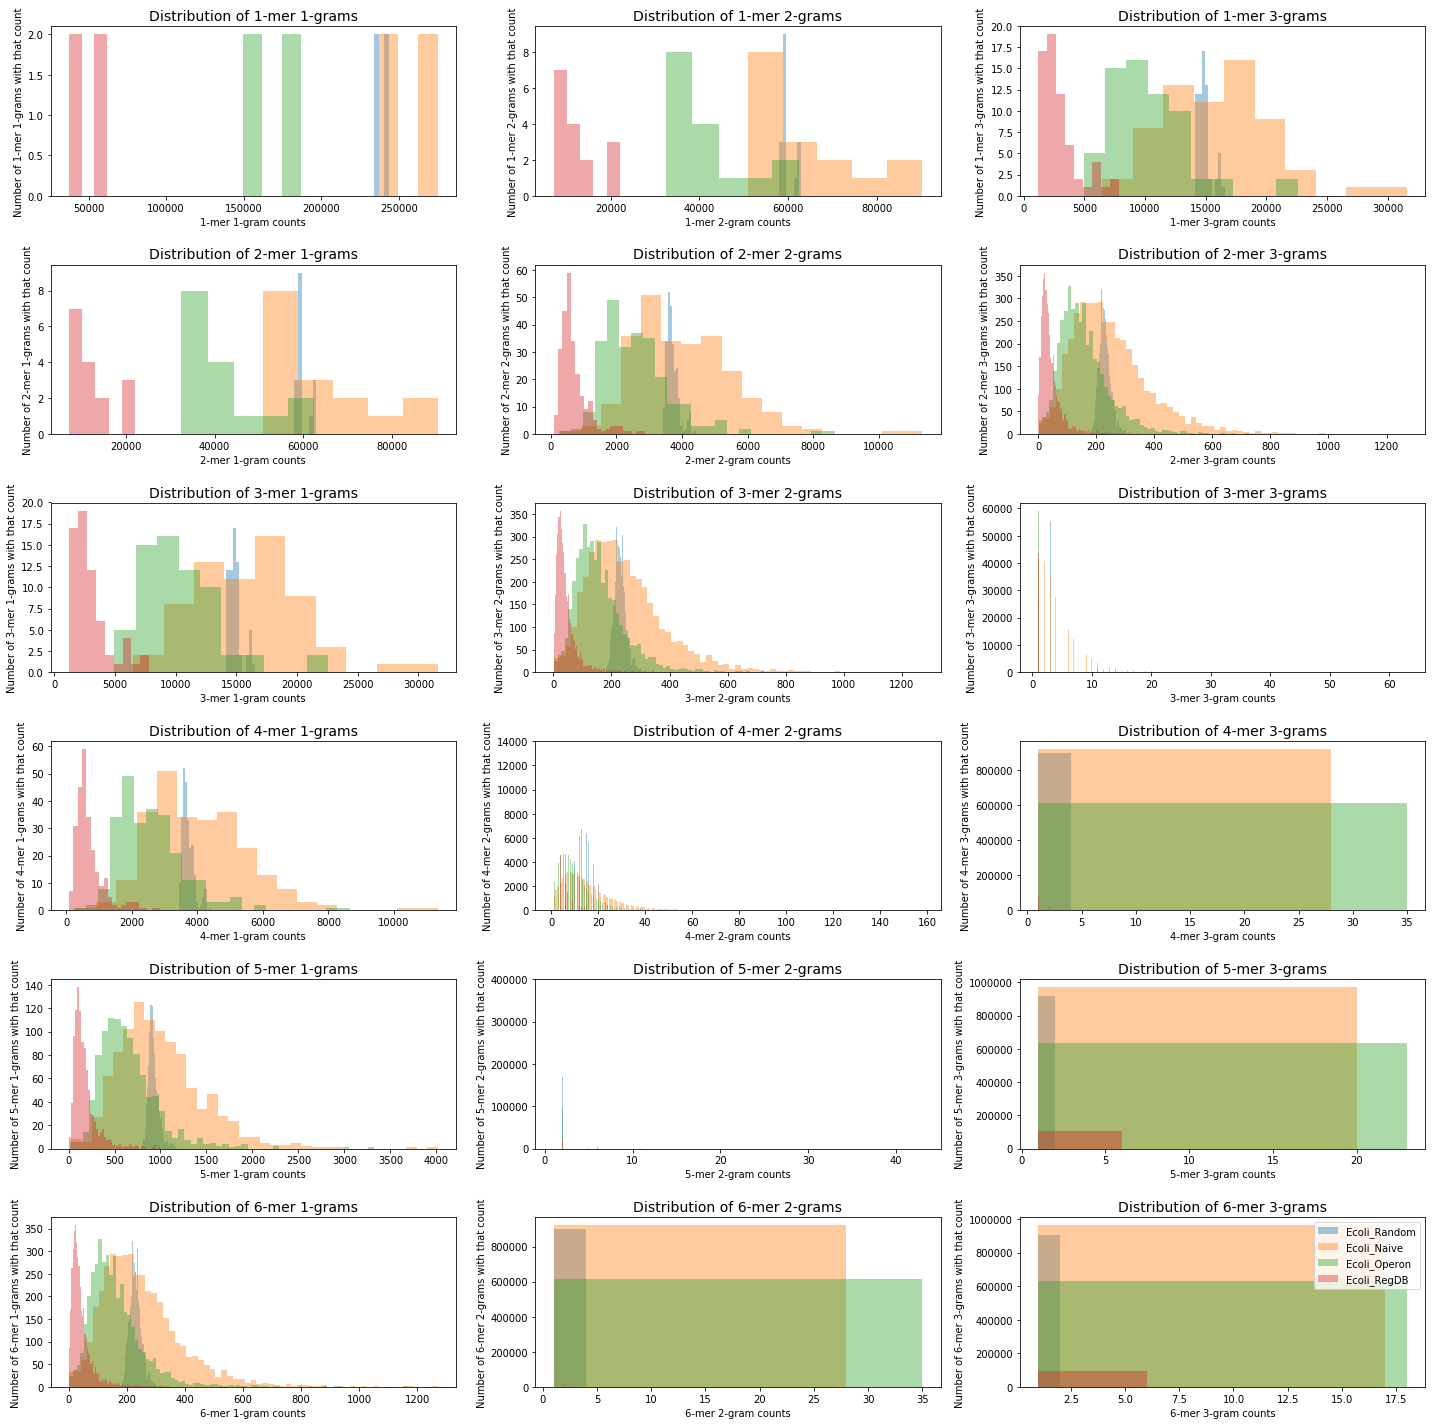

In [39]:
combo_subset = [
    (1,1),(1,2),(1,3),
    (2,1),(2,2),(2,3),
    (3,1),(3,2),(3,3),
    (4,1),(4,2),(4,3),
    (5,1),(5,2),(5,3),
    (6,1),(6,2),(6,3)
]
hist_grid(combo_subset,all_results, 6, 3)

In [42]:
def hist_grid_freq(model_combos,p_set_results, num_rows, num_cols):
    # Create a small multiples plot of distribution across model grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
    axes_list = [item for sublist in axes for item in sublist] 

    for k,n in model_combos:
        ax = axes_list.pop(0)
        for p_set in p_set_results: # dictionary of p-sets with all model combos
            res = p_set_results[p_set]
            # get the numerator counts to plot
            data = [res[(k,n)]['freq'][x] for x in res[(k,n)]['num']]
            # plot in ax
            ax.hist(data,label=p_set, alpha=0.4, bins='auto')
            ax.legend()
            
        ax.set_title("Distribution of %i-mer %i-grams" % (k,n), fontsize=14)
        ax.set_xlabel("%i-mer %i-gram counts" % (k,n))
        ax.set_ylabel("Number of %i-mer %i-grams with that count" % (k,n))

    for ax in axes_list:
        ax.remove()

    
    plt.tight_layout()

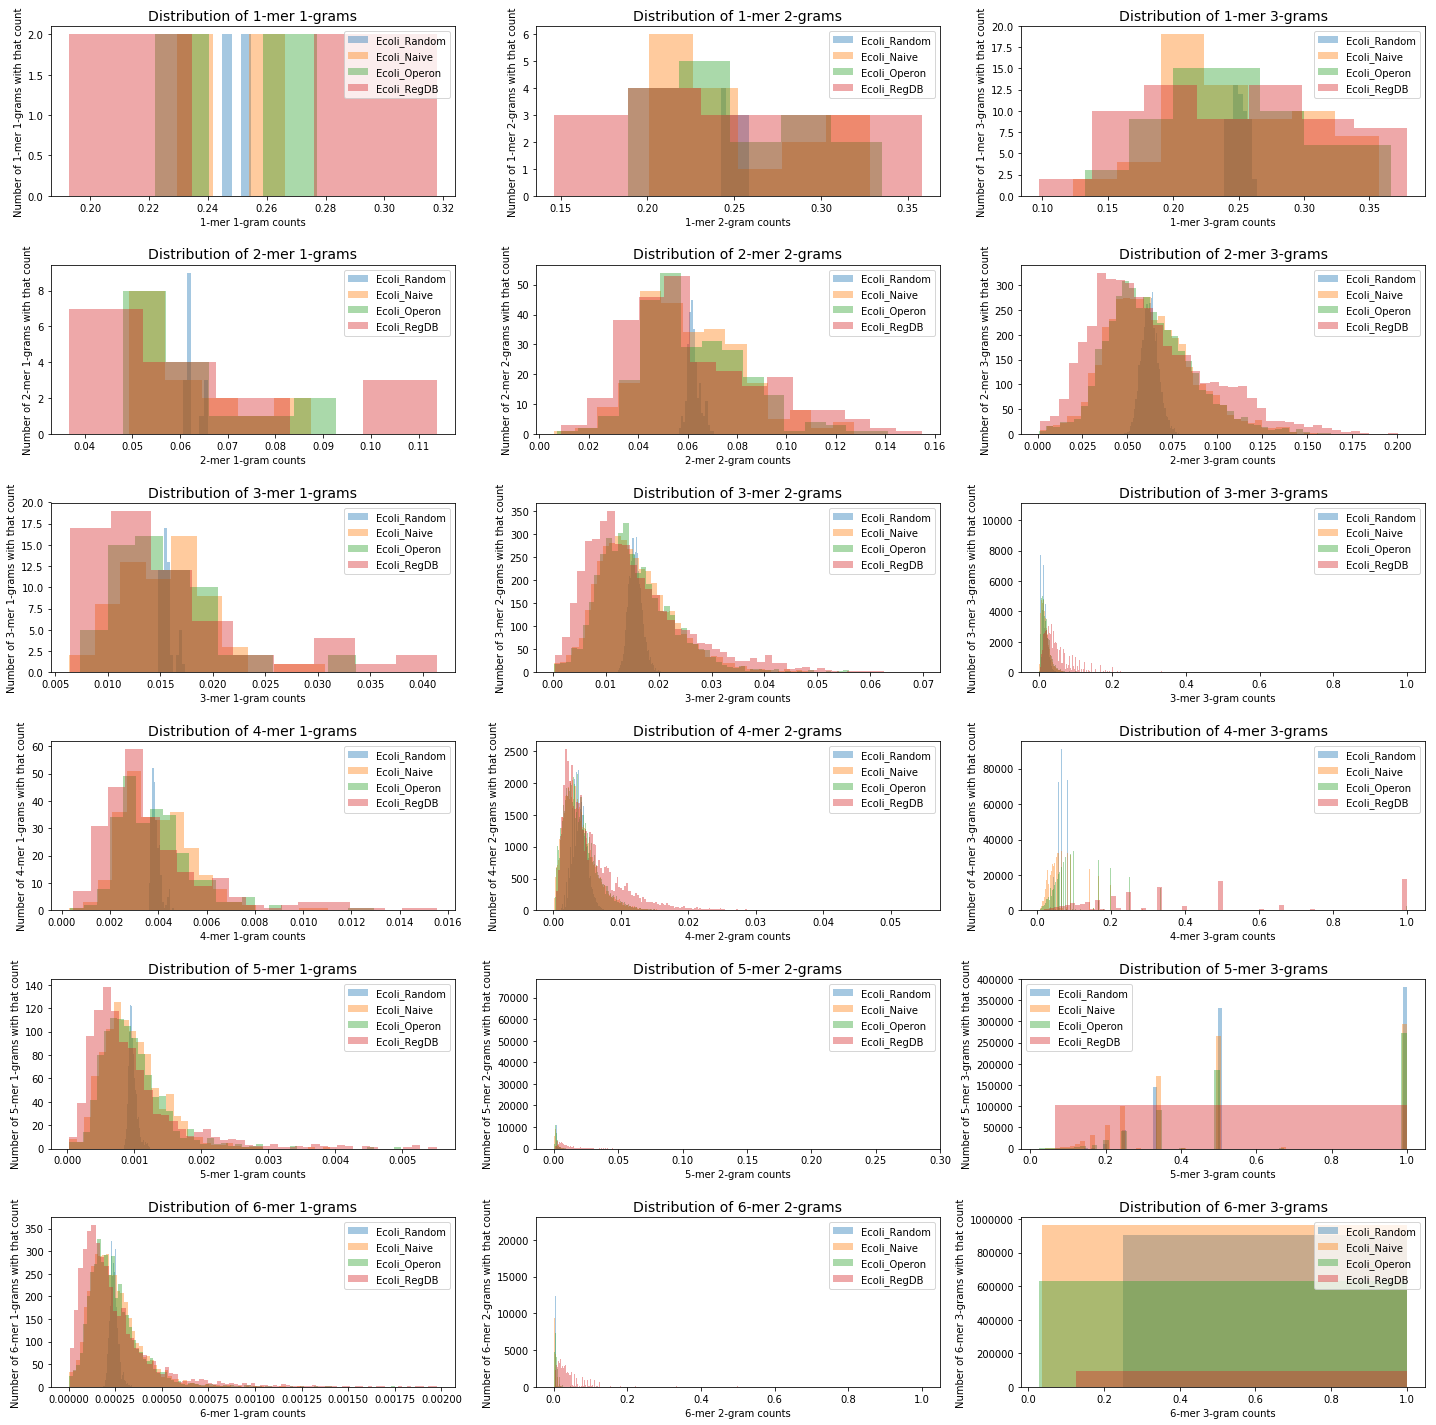

In [43]:
hist_grid_freq(combo_subset,all_results, 6, 3)

# Calculating Perplexity 
With all the frequency look up tables calculated and stored in `all_results`, now we can evaluate the perplexity of each corpus (some k-mer, n-gram model for a given promoter set (Naive, Operon, Random, RegDB). Perplexity was calculated as described in NLP lecture slides: https://courses.cs.washington.edu/courses/cse517/19wi/slides/LanguageModels.pdf

pseudo-y code for corpus level perplexity
```
sentence_probs = []

for sentence in corpus:
    word_probs = []
    
    for word in sentence:
        w = prob_lookup_table[word]
        word_probs.append(w)
        
    sentence_prob = multiply(word_probs)
    sentence_probs.append(sentence_prob)
    
log_sum = sum([log2(s) for s in sentence probs])
ave_log_sum = log_sum/len(sentences)

perplexity = 2**(-ave_log_sum)
``` 

In [35]:
all_results['Ecoli_Random'][(1,1)].keys()

dict_keys(['num', 'denom', 'freq', 'train_seq_grams', 'dev_seq_grams', 'test_seq_grams'])

In [36]:
def calculate_corpus_perplexity(corpus, k, n, freq_table, numer_table, denom_table, x_smoothing=None):
    '''
    Given a corpus of sequences that have already been broken up into
    n-grams and a probability lookup table constructed specifically for 
    that k-mer,n-gram size, calculate the perplexity of the corpus.
    
    If smoothing is specified, instead of using the exact count, 
    instead add x to the numerator and 4^(k*n)*x to the denominator.
    '''
    
    def get_freq(ngram):
        ''' If no smoothing is requested, just return the freq lookup'''
        ngram = list2key(ngram)
        
        # collect the log2 probability of the ngram
        if ngram not in freq_table:
            w_log = np.float('-inf')
        else:
            w_log = np.log2(freq_table[ngram])
        
        return w_log
        
    def get_smoothed_freq(ngram):
        ''' 
        If smoothing IS requested, add x to the numer count and 4^(k*n)
        to the denom count.
        
        NOTE: I think this is incorrect... needs debugging...
        '''
        #print("---Smoothing", ngram)
        denom_ngram = list2key(ngram[:-1])
        ngram = list2key(ngram)
        
        #denom_ngram = ngram[:-1]
        
        # check if ngram in numerator table
        if ngram not in numer_table:
#             print(ngram, "not in table?")
#             print(numer_table)
            num_val = x_smoothing
        else: 
            num_val = numer_table[ngram] + x_smoothing
            
        #print("Num val:", num_val)
            
        # if denom-ngram is in denom table
        if denom_ngram not in denom_table:
            # if its a unigram model, use the word count as the denominator
            if n == 1:
                denom_val = denom_table['count'] + (4**(k))*x_smoothing
            # if its not unigram and just missing, just use the smoothing val
            # times the number of possible words.
            else:
                denom_val = (4**(k*n))*x_smoothing
        else: 
            denom_val = denom_table[denom_ngram] + (4**(k))*x_smoothing
        #print("denom val:", denom_val)
        
        # return the log of the frequency
        w_log = np.log2(num_val/denom_val)
        return w_log
    
    seq_log_probs = [] # log probability across each sequence
    N = 0 # number of words, aka ngrams in the corpus
          # for this, I just need to count the first word 
          # (because the later words will show up in the next gram)
          # so really, just count the number of n-grams
    
    # for each n-gram'd sequence in the promoter set
    for seq in corpus:
        ngram_log_probs = [] 
        # for each n-gram
        for ngram in seq:
            # get smoothed or normal version depending on x_smoothing status
            # (or if k and n are 1 or 2, we'll for sure be ok not smoothing)
            if not x_smoothing:# or (k<3 and n<3):
                w_log = get_freq(ngram)
            else: 
                w_log = get_smoothed_freq(ngram)
                
            #w_log = get_smoothed_freq(ngram) if x_smoothing else get_freq(ngram)
                
            ngram_log_probs.append(w_log)
            
            # increment the word counter
            N += 1 
            
        # after collecting all the log probabilites for each ngram 
        # in the sequence, sum them to get the overall sequence prob
        seq_log_prob = sum(ngram_log_probs)
        seq_log_probs.append(seq_log_prob)
    
    # After collecting all the sequence log probabilities in the corpus,
    # take their average over all the words in the corpus (accumulated in N)
    ave_log_sum = sum(seq_log_probs) / N
    
    # get the perplexity
    perplexity = 2**(-ave_log_sum)
    return perplexity
        
        
        

In [37]:
def get_perplexity_scores(p_set_name, k, n, x_smoothing=None):
    '''
    Given a promoter set, takes its ngramd corpus and calcualte the 
    perplexity for the train and dev sets
    '''
    
    train = all_results[p_set_name][(k,n)]['train_seq_grams']
    dev = all_results[p_set_name][(k,n)]['dev_seq_grams']
    test = all_results[p_set_name][(k,n)]['test_seq_grams']
    
    freq_table = all_results[p_set_name][(k,n)]['freq']
    numer_table = all_results[p_set_name][(k,n)]['num']
    denom_table = all_results[p_set_name][(k,n)]['denom']

    pp_train = calculate_corpus_perplexity(train, 
                                           k,n,
                                           freq_table, 
                                           numer_table, 
                                           denom_table,
                                           x_smoothing=x_smoothing)
    
    pp_dev = calculate_corpus_perplexity(dev, 
                                         k,n,
                                         freq_table, 
                                         numer_table, 
                                         denom_table,
                                         x_smoothing=x_smoothing)

    return pp_train, pp_dev

## collect perplexity scores into a dataframe


In [38]:
pp_data = []
pp_data_smooth = []

for p_set_name in all_results:
    for k,n in model_combos:
        print("Calculating perplexity for %i-mer %i-grams, %s" %(k,n,p_set_name))
        
        # Unsmoothed
        pp_train, pp_dev = get_perplexity_scores(p_set_name, k, n)
        
        # x-smoothing attempt 
        pp_train_smooth, pp_dev_smooth = get_perplexity_scores(p_set_name, k, n, x_smoothing=0.01)

        row = [p_set_name, k,n,pp_train, pp_dev]
        pp_data.append(row)
        
        row_smooth = [p_set_name, k,n,pp_train_smooth, pp_dev_smooth]
        pp_data_smooth.append(row_smooth)
        


Calculating perplexity for 1-mer 1-grams, Ecoli_Random
Calculating perplexity for 1-mer 2-grams, Ecoli_Random
Calculating perplexity for 1-mer 3-grams, Ecoli_Random
Calculating perplexity for 1-mer 4-grams, Ecoli_Random
Calculating perplexity for 1-mer 5-grams, Ecoli_Random
Calculating perplexity for 1-mer 6-grams, Ecoli_Random
Calculating perplexity for 1-mer 7-grams, Ecoli_Random
Calculating perplexity for 1-mer 8-grams, Ecoli_Random
Calculating perplexity for 2-mer 1-grams, Ecoli_Random
Calculating perplexity for 2-mer 2-grams, Ecoli_Random
Calculating perplexity for 2-mer 3-grams, Ecoli_Random
Calculating perplexity for 3-mer 1-grams, Ecoli_Random
Calculating perplexity for 3-mer 2-grams, Ecoli_Random
Calculating perplexity for 3-mer 3-grams, Ecoli_Random
Calculating perplexity for 4-mer 1-grams, Ecoli_Random
Calculating perplexity for 4-mer 2-grams, Ecoli_Random
Calculating perplexity for 4-mer 3-grams, Ecoli_Random
Calculating perplexity for 5-mer 1-grams, Ecoli_Random
Calculatin

In [39]:
pp_df = pd.DataFrame(pp_data, 
                     columns=['promoter_set', 
                              'k', 'n', 
                              'train_perplexity', 
                              'dev_perplexity'])

pp_df_smooth = pd.DataFrame(pp_data_smooth, 
                     columns=['promoter_set', 
                              'k', 'n', 
                              'train_perplexity', 
                              'dev_perplexity'])

# DUMMY FOR NOW. UNDO LATER?
#pp_df.to_csv("results/ecoli_perplexity_scores_ADDX_SMOOTHED.csv", index=False)

In [2]:
# read from csv's if we've already made them 

#pp_df = pd.read_csv("results/ecoli_perplexity_scores.csv")
#pp_df = pd.read_csv("results/ecoli_perplexity_scores_SMOOTHED.csv")
pp_df = pd.read_csv("results/ecoli_perplexity_scores_ADDX_SMOOTHED.csv")

#pp_df.head(20)

In [40]:
pp_df_smooth.to_csv('results/pp_df_smooth.csv', index=False)
pp_df.to_csv('results/pp_df_NOTsmooth.csv', index=False)

In [2]:
pp_df = pd.read_csv('results/pp_df_NOTsmooth.csv')
pp_df_smooth = pd.read_csv('results/pp_df_smooth.csv')


In [3]:
pp_df_smooth

,promoter_set,k,n,train_perplexity,dev_perplexity
0,Ecoli_Random,1,1,3.999367,3.999362e+00
1,Ecoli_Random,1,2,3.999101,3.999028e+00
2,Ecoli_Random,1,3,3.998793,3.998902e+00
3,Ecoli_Random,1,4,3.998301,3.998878e+00
4,Ecoli_Random,1,5,3.996803,3.999942e+00
5,Ecoli_Random,1,6,3.991983,4.004384e+00
6,Ecoli_Random,1,7,3.971938,4.024606e+00
7,Ecoli_Random,1,8,3.891891,4.116800e+00
8,Ecoli_Random,2,1,15.993873,1.599356e+01
9,Ecoli_Random,2,2,15.988384,1.599118e+01


In [4]:
pp_df

,promoter_set,k,n,train_perplexity,dev_perplexity
0,Ecoli_Random,1,1,3.999367,3.999362
1,Ecoli_Random,1,2,3.999101,3.999028
2,Ecoli_Random,1,3,3.998793,3.998902
3,Ecoli_Random,1,4,3.998301,3.998878
4,Ecoli_Random,1,5,3.996803,3.999942
5,Ecoli_Random,1,6,3.991983,4.004384
6,Ecoli_Random,1,7,3.971938,4.024616
7,Ecoli_Random,1,8,3.891891,4.116990
8,Ecoli_Random,2,1,15.993873,15.993563
9,Ecoli_Random,2,2,15.988384,15.991178


# Plot model perplexities
After calculating the perplexities, I tried a couple different visualization techniques. I decided to work with "normalized" perplexity because depending on your choice of `k`, the "worst possible perplexity" changes (max perplexity should be about the size of your vocabulary. Vocabulary changes depending on the size of the k-mer). Therefore, in "normalized perplexity", I take the raw score and divide it by 4^k. Anything close to 1.0 should be "as perplexing as can be" while smaller values are less perplexing. This allows us to compare models across different `k`s. 

First, I tried a heatmap. This was to allow the viewer to see small difference in perplexity as you change values of `n` and `k`.

Second, I tried a bar chart. I organized the bars by promoter set to allow for more direct comparison between the promoter corpora (less focused on choices of hyper parameters)



In [16]:
def make_heatmap_for_promoter_set(res_df, p_set_name):
    df = res_df.loc[res_df['promoter_set'] == p_set_name]

    df['worst_pp'] = df['k'].apply(lambda x: 4**x)
    df['dev_no_inf'] =  df.apply(lambda row: row['worst_pp']*1.2 if math.isinf(row['dev_perplexity']) else row['dev_perplexity'], axis=1)
    df['norm_dev_pp'] = df['dev_no_inf']/df['worst_pp']    
    
    # not normalized perplexities
    # This is just to show why using normalized perplexity is better!
#     df_piv = df.pivot("k", "n", "dev_perplexity")

#     mask = df_piv.isnull()
#     ax = sns.heatmap(df_piv, mask=mask, vmin=0, vmax=5000,cmap='viridis_r')
#     plt.title("Raw Perplexity (%s)" % p_set_name)
#     plt.show()
    
    # using normed perplexities
    df_piv_norm = df.pivot("k", "n", "norm_dev_pp")
    mask_norm = df_piv_norm.isnull()
    ax_norm = sns.heatmap(df_piv_norm, mask=mask_norm, vmin=0.5, vmax=1.5,cmap='viridis_r')
    #ax_norm = sns.heatmap(df_piv_norm, mask=mask_norm,cmap='viridis_r')
    plt.title("Relative to worst perplexity (%s)" % p_set_name)
    plt.show()
    
    return df
    

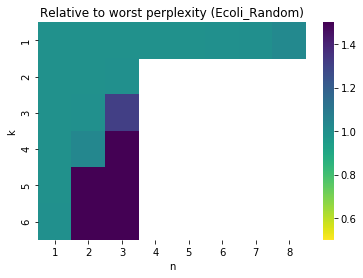

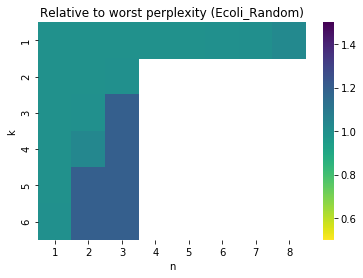

In [17]:
rand_smooth = make_heatmap_for_promoter_set(pp_df_smooth, "Ecoli_Random")
rand = make_heatmap_for_promoter_set(pp_df, "Ecoli_Random")

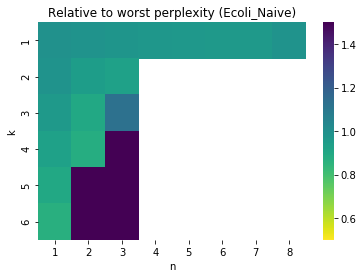

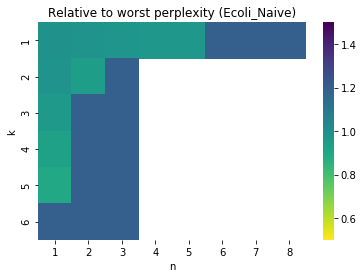

In [18]:
naive_smooth = make_heatmap_for_promoter_set(pp_df_smooth, "Ecoli_Naive")
naive = make_heatmap_for_promoter_set(pp_df, "Ecoli_Naive")

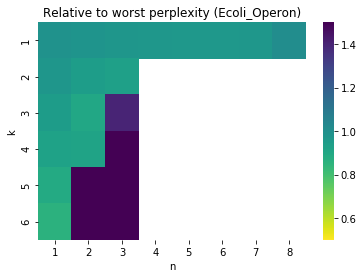

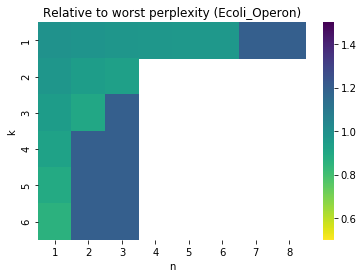

In [20]:
operon_smooth = make_heatmap_for_promoter_set(pp_df_smooth, "Ecoli_Operon")
operon = make_heatmap_for_promoter_set(pp_df, "Ecoli_Operon")

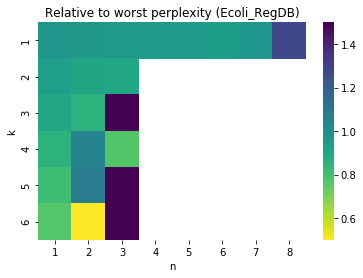

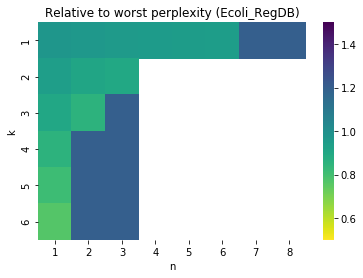

In [21]:
reg_smooth = make_heatmap_for_promoter_set(pp_df_smooth, "Ecoli_RegDB")
reg = make_heatmap_for_promoter_set(pp_df, "Ecoli_RegDB")

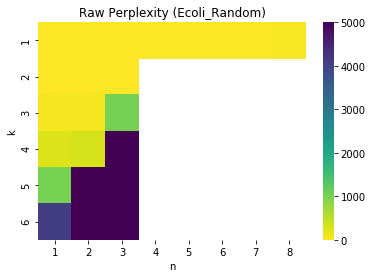

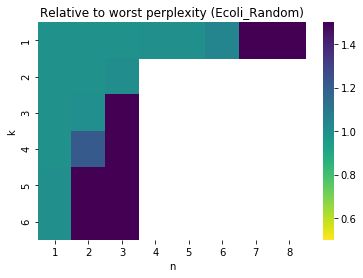

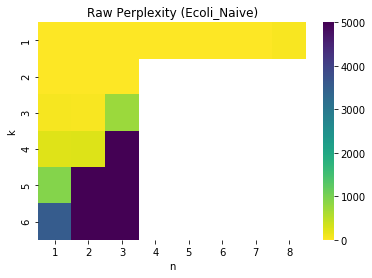

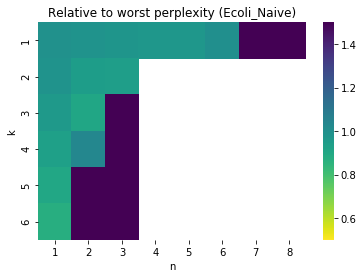

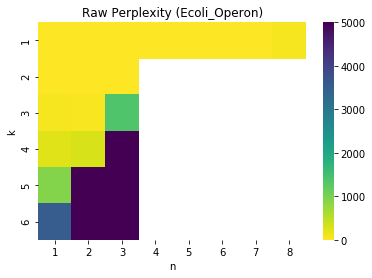

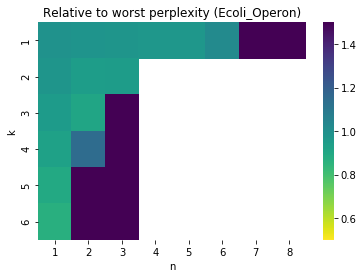

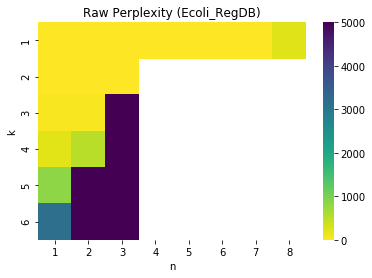

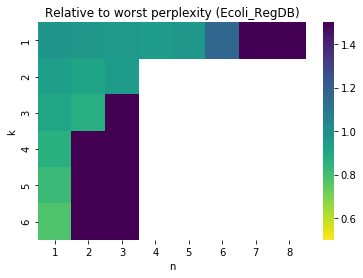

In [4]:
make_heatmap_for_promoter_set(pp_df, "Ecoli_Random")
make_heatmap_for_promoter_set(pp_df, "Ecoli_Naive")
make_heatmap_for_promoter_set(pp_df, "Ecoli_Operon")
make_heatmap_for_promoter_set(pp_df, "Ecoli_RegDB")

In [30]:
def make_barchart_for_promoter_set(res_df, n):
    df = res_df.loc[res_df['n'] == n]

    df['worst_pp'] = df['k'].apply(lambda x: 4**x)
    df['dev_no_inf'] =  df.apply(lambda row: row['worst_pp']*1.2 if math.isinf(row['dev_perplexity']) else row['dev_perplexity'], axis=1)
    df['norm_train_pp'] = df['train_perplexity']/df['worst_pp']
    df['norm_dev_pp'] = df['dev_no_inf']/df['worst_pp']    
    
    # not normalized perplexities
    #df_piv = df.pivot("k", "n", "dev_perplexity")

    sns.catplot(x="k", y="norm_dev_pp",
                 hue="promoter_set", col="n",
                 data=df, kind="bar"
                 )
    
    print(df.loc[df['k']==6])
    
    plt.ylim(0.5,1.2)
    plt.xlabel("k-mer size")
    plt.ylabel("Normalized dev set perplexity")
    plt.show()

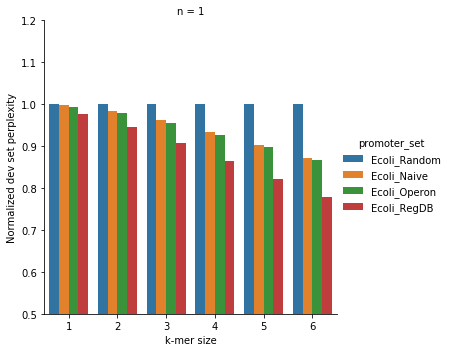

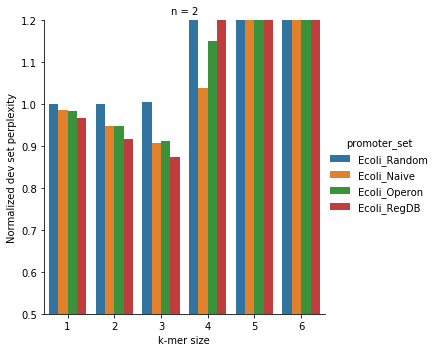

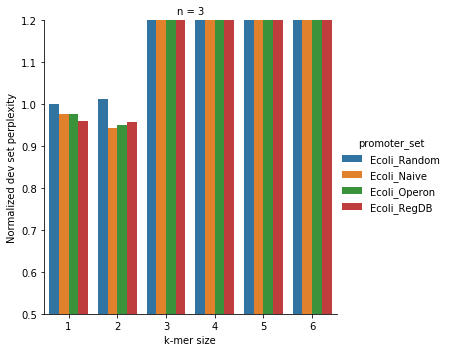

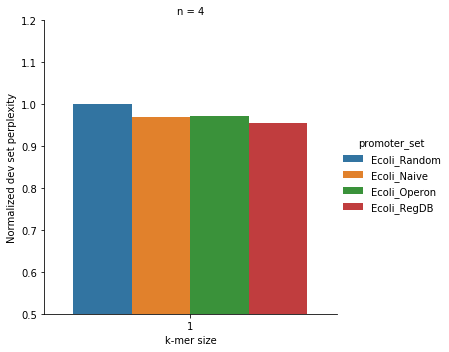

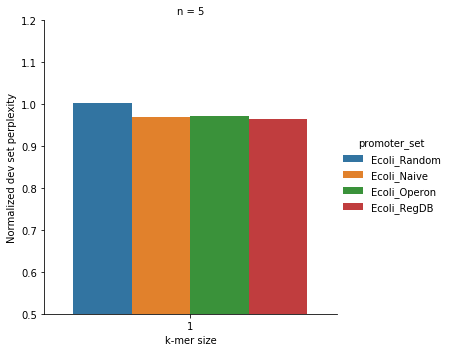

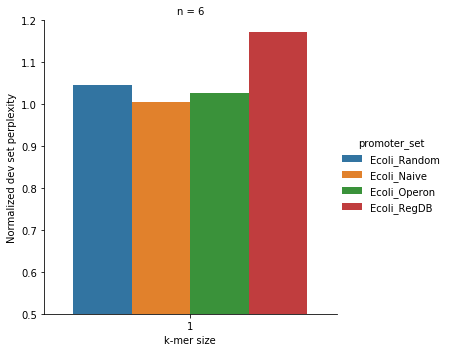

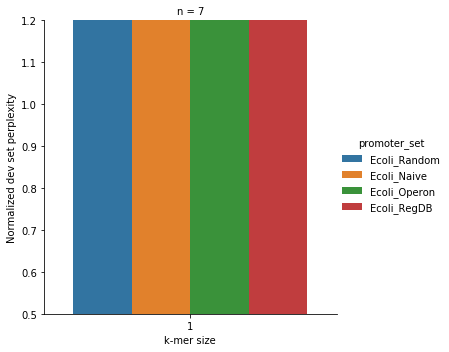

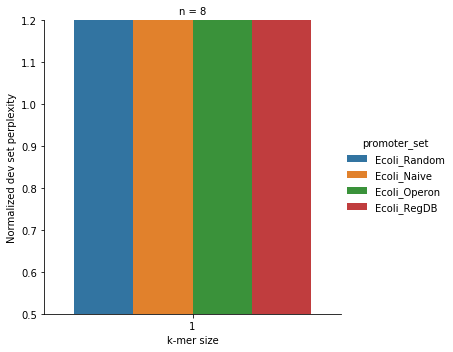

In [6]:
# add x smoothing
make_barchart_for_promoter_set(pp_df, 1)
make_barchart_for_promoter_set(pp_df, 2)
make_barchart_for_promoter_set(pp_df, 3)
make_barchart_for_promoter_set(pp_df, 4)
make_barchart_for_promoter_set(pp_df, 5)
make_barchart_for_promoter_set(pp_df, 6)
make_barchart_for_promoter_set(pp_df, 7)
make_barchart_for_promoter_set(pp_df, 8)

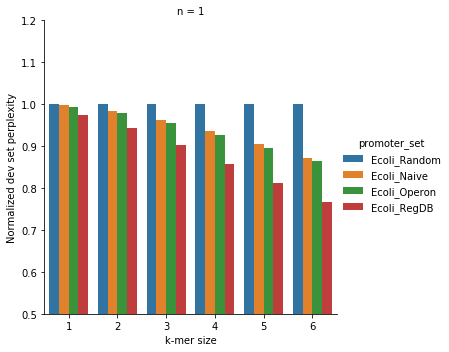

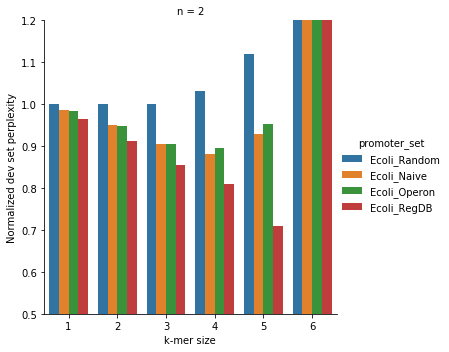

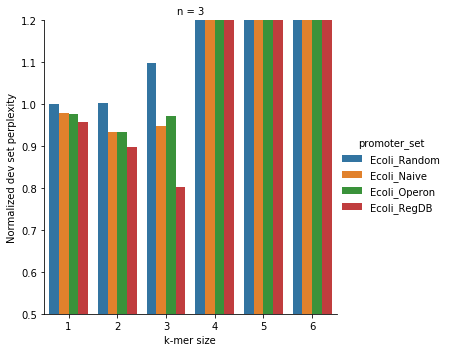

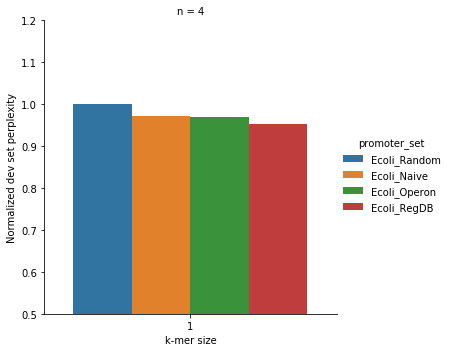

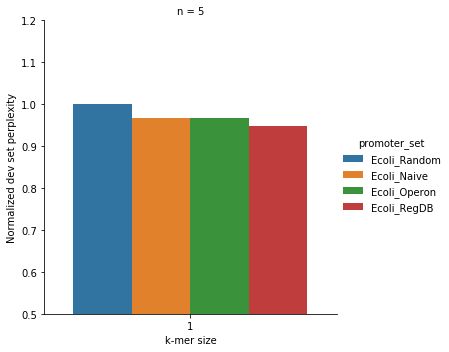

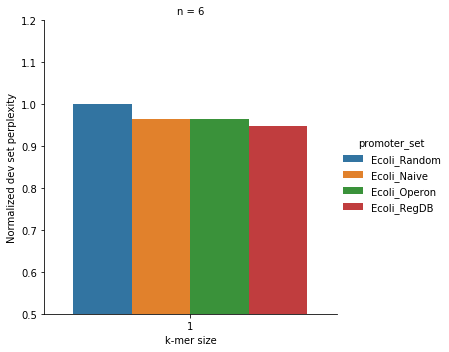

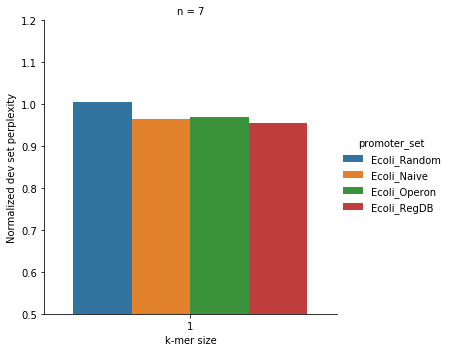

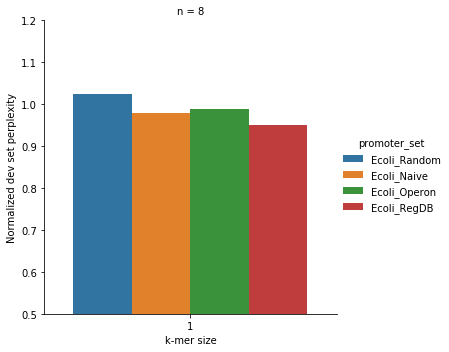

In [18]:
# leftover charts from pre-smoothed data... I see fewer infinities here for some reason... 
# again, probably due to incorrect smoothing implementation >.<

# make_barchart_for_promoter_set(pp_df, 1)
# make_barchart_for_promoter_set(pp_df, 2)
# make_barchart_for_promoter_set(pp_df, 3)
# make_barchart_for_promoter_set(pp_df, 4)
# make_barchart_for_promoter_set(pp_df, 5)
# make_barchart_for_promoter_set(pp_df, 6)
# make_barchart_for_promoter_set(pp_df, 7)
# make_barchart_for_promoter_set(pp_df, 8)

In [ ]:
# redo k smoothing

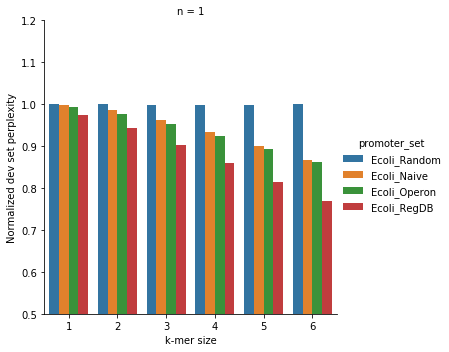

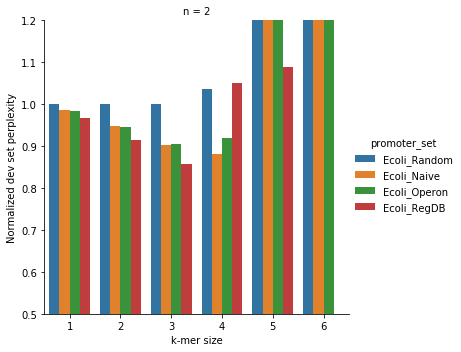

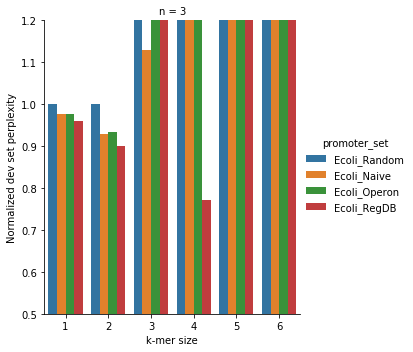

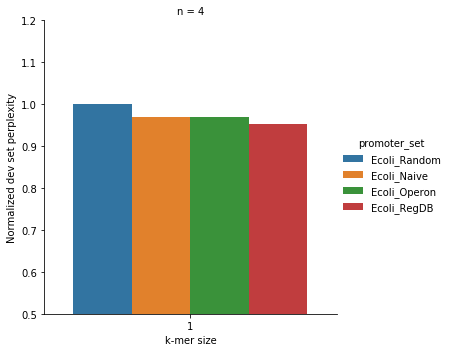

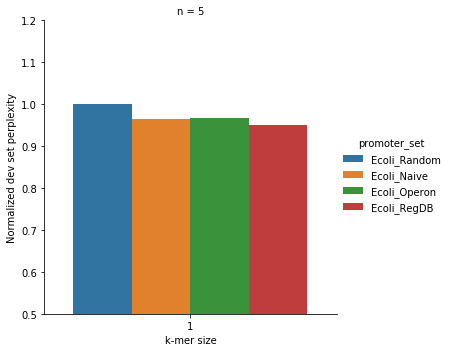

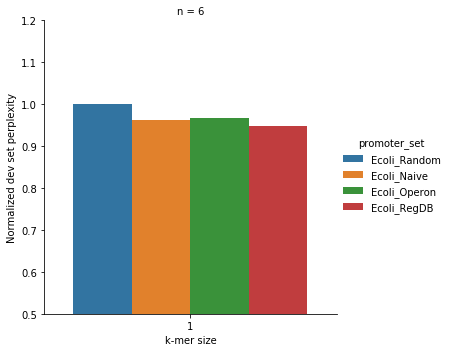

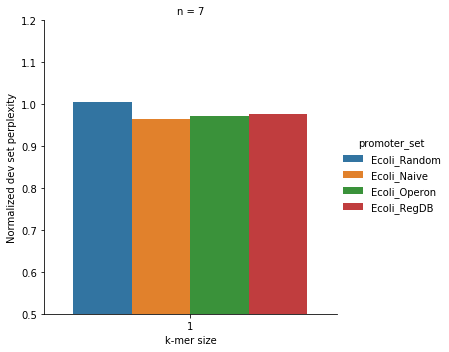

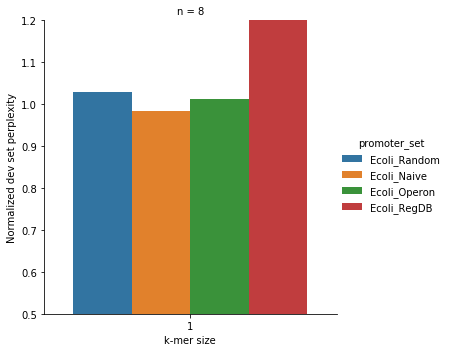

In [24]:
# add x smoothing
make_barchart_for_promoter_set(pp_df_smooth, 1)
make_barchart_for_promoter_set(pp_df_smooth, 2)
make_barchart_for_promoter_set(pp_df_smooth, 3)
make_barchart_for_promoter_set(pp_df_smooth, 4)
make_barchart_for_promoter_set(pp_df_smooth, 5)
make_barchart_for_promoter_set(pp_df_smooth, 6)
make_barchart_for_promoter_set(pp_df_smooth, 7)
make_barchart_for_promoter_set(pp_df_smooth, 8)

In [25]:
pp_df_smooth

,promoter_set,k,n,train_perplexity,dev_perplexity
0,Ecoli_Random,1,1,3.999367,3.999362e+00
1,Ecoli_Random,1,2,3.999101,3.999028e+00
2,Ecoli_Random,1,3,3.998793,3.998902e+00
3,Ecoli_Random,1,4,3.998301,3.998878e+00
4,Ecoli_Random,1,5,3.996803,3.999942e+00
5,Ecoli_Random,1,6,3.991983,4.004384e+00
6,Ecoli_Random,1,7,3.971938,4.024606e+00
7,Ecoli_Random,1,8,3.891891,4.116800e+00
8,Ecoli_Random,2,1,15.993873,1.599356e+01
9,Ecoli_Random,2,2,15.988384,1.599118e+01


    promoter_set  k  n  train_perplexity  dev_perplexity  worst_pp  \
21  Ecoli_Random  6  2        255.296653    20601.856191      4096   
44   Ecoli_Naive  6  2        287.397635    16822.524209      4096   
67  Ecoli_Operon  6  2        209.785339    14323.389237      4096   
90   Ecoli_RegDB  6  2         65.634284      996.286655      4096   

      dev_no_inf  norm_train_pp  norm_dev_pp  
21  20601.856191       0.062328     5.029750  
44  16822.524209       0.070165     4.107062  
67  14323.389237       0.051217     3.496921  
90    996.286655       0.016024     0.243234  


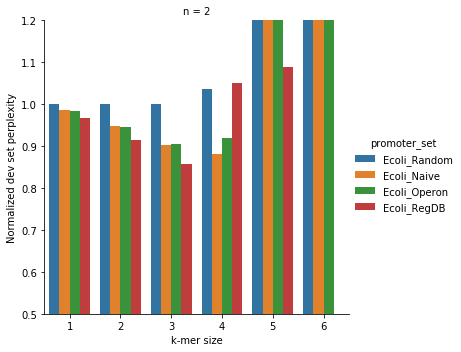

In [31]:
make_barchart_for_promoter_set(pp_df_smooth, 2)


# Calculate Perplexity across a sequence
While the above charts allow us to compare perplexity across model params and promoter sets, I was also interested in seeing if there were any interesting patterns that came from plotting perplexity across any given sequence. The hope would be to find regions in the sequence of particularly *low* perplexity, which maybe indicated the *true* signal of the promoter sequence. 

Here is some _very_ preliminary tinkering for the "future directions" part of my project

In [66]:
def get_seq_perplexity_vec(seq, k, n, freq_lookup):
    '''
    Given a sequence and a k,n and freq lookup table, return a vector of perplexity 
    scores at every point in the sequence
    '''
    
    # loop through the end of the sequence (minus the distance of the last full gram)
    stop_coord = -((k*n)-1)
    if stop_coord == 0:
        stop_coord = -1
    
    pp_vec = []
    
    # loop through every nucleotide
    for i,nuc in enumerate(seq[:stop_coord]):
        grams = [] # collect the n-gram (aka bi or trigram)
        for step in range(n):
            # i is the current loc in the seq
            # k is the size of the mer to get
            # k*step is the offset within the n-gram (aka first 3-mer vs second 3-mer in a bigram)
            gram = seq[i+(k*step):i+k+(k*step)]
            grams.append(gram)
        
        # convert n-gram we just collected to a key
        ngram = list2key(grams)
        
        # lookup in the frequ table
        w_log = np.float('-inf') if ngram not in freq_lookup else np.log2(freq_lookup[ngram])
        pp_score = 2**(-w_log)
        pp_vec.append(pp_score)
    
    return pp_vec
    
    

def get_perplexity_across_sequences(p_sets_to_try, model_combos):
    '''
    Given a set of corpii and model combos, loop through each sequence in the corpus
    and get a vector of perplexity scores (perplexity at ever step in the seq). 
    '''
    
    for corpus, p_set_name in p_sets_to_try:
        # df of seq_name, k,n, pos, pp_score
        data = []
        for k,n in model_combos:
            print("Calculating pp vecs for %i-mer %i-gram for %s" %(k,n,p_set_name))
            for i,(seq_name, seq) in enumerate(corpus):
                if i%500 == 0:
                    print("\tSeq %i of %i" % (i, len(corpus)))
                    
                freq_lookup = all_results[p_set_name][(k,n)]['freq']
                pp_vec = get_seq_perplexity_vec(seq, k, n, freq_lookup)
                
                # make a new row for the df
                for pos,pp_val in enumerate(pp_vec):
                    row = [seq_name, k,n,pos,pp_val, seq]
                    data.append(row)
                
        df = pd.DataFrame(data, 
                          columns=['seq_name', 
                                  'k', 'n', 
                                  'pos', 
                                  'perplexity',
                                  'seq'])
        
        filename = "pp_vector_dfs/"+p_set_name+"_pp_vector.csv"
        df.to_csv(filename, index=False)
    
    
    return pp_train, pp_dev

In [67]:
get_perplexity_across_sequences(p_sets_to_try, model_combos)

Calculating pp vecs for 1-mer 1-gram for Ecoli_Random
	Seq 0 of 4000
	Seq 500 of 4000
	Seq 1000 of 4000
	Seq 1500 of 4000
	Seq 2000 of 4000
	Seq 2500 of 4000
	Seq 3000 of 4000
	Seq 3500 of 4000
Calculating pp vecs for 1-mer 2-gram for Ecoli_Random
	Seq 0 of 4000
	Seq 500 of 4000
	Seq 1000 of 4000
	Seq 1500 of 4000
	Seq 2000 of 4000
	Seq 2500 of 4000
	Seq 3000 of 4000
	Seq 3500 of 4000
Calculating pp vecs for 1-mer 3-gram for Ecoli_Random
	Seq 0 of 4000
	Seq 500 of 4000
	Seq 1000 of 4000
	Seq 1500 of 4000
	Seq 2000 of 4000
	Seq 2500 of 4000
	Seq 3000 of 4000
	Seq 3500 of 4000
Calculating pp vecs for 1-mer 4-gram for Ecoli_Random
	Seq 0 of 4000
	Seq 500 of 4000
	Seq 1000 of 4000
	Seq 1500 of 4000
	Seq 2000 of 4000
	Seq 2500 of 4000
	Seq 3000 of 4000
	Seq 3500 of 4000
Calculating pp vecs for 1-mer 5-gram for Ecoli_Random
	Seq 0 of 4000
	Seq 500 of 4000
	Seq 1000 of 4000
	Seq 1500 of 4000
	Seq 2000 of 4000
	Seq 2500 of 4000
	Seq 3000 of 4000
	Seq 3500 of 4000
Calculating pp vecs for 1-mer 

	Seq 3000 of 4320
	Seq 3500 of 4320
	Seq 4000 of 4320
Calculating pp vecs for 5-mer 2-gram for Ecoli_Naive
	Seq 0 of 4320
	Seq 500 of 4320
	Seq 1000 of 4320
	Seq 1500 of 4320
	Seq 2000 of 4320
	Seq 2500 of 4320
	Seq 3000 of 4320
	Seq 3500 of 4320
	Seq 4000 of 4320
Calculating pp vecs for 5-mer 3-gram for Ecoli_Naive
	Seq 0 of 4320
	Seq 500 of 4320
	Seq 1000 of 4320
	Seq 1500 of 4320
	Seq 2000 of 4320
	Seq 2500 of 4320
	Seq 3000 of 4320
	Seq 3500 of 4320
	Seq 4000 of 4320
Calculating pp vecs for 6-mer 1-gram for Ecoli_Naive
	Seq 0 of 4320
	Seq 500 of 4320
	Seq 1000 of 4320
	Seq 1500 of 4320
	Seq 2000 of 4320
	Seq 2500 of 4320
	Seq 3000 of 4320
	Seq 3500 of 4320
	Seq 4000 of 4320
Calculating pp vecs for 6-mer 2-gram for Ecoli_Naive
	Seq 0 of 4320
	Seq 500 of 4320
	Seq 1000 of 4320
	Seq 1500 of 4320
	Seq 2000 of 4320
	Seq 2500 of 4320
	Seq 3000 of 4320
	Seq 3500 of 4320
	Seq 4000 of 4320
Calculating pp vecs for 6-mer 3-gram for Ecoli_Naive
	Seq 0 of 4320
	Seq 500 of 4320
	Seq 1000 of 4320

	Seq 500 of 5444
	Seq 1000 of 5444
	Seq 1500 of 5444
	Seq 2000 of 5444
	Seq 2500 of 5444
	Seq 3000 of 5444
	Seq 3500 of 5444
	Seq 4000 of 5444
	Seq 4500 of 5444
	Seq 5000 of 5444
Calculating pp vecs for 4-mer 2-gram for Ecoli_RegDB
	Seq 0 of 5444
	Seq 500 of 5444
	Seq 1000 of 5444
	Seq 1500 of 5444
	Seq 2000 of 5444
	Seq 2500 of 5444
	Seq 3000 of 5444
	Seq 3500 of 5444
	Seq 4000 of 5444
	Seq 4500 of 5444
	Seq 5000 of 5444
Calculating pp vecs for 4-mer 3-gram for Ecoli_RegDB
	Seq 0 of 5444
	Seq 500 of 5444
	Seq 1000 of 5444
	Seq 1500 of 5444
	Seq 2000 of 5444
	Seq 2500 of 5444
	Seq 3000 of 5444
	Seq 3500 of 5444
	Seq 4000 of 5444
	Seq 4500 of 5444
	Seq 5000 of 5444
Calculating pp vecs for 5-mer 1-gram for Ecoli_RegDB
	Seq 0 of 5444
	Seq 500 of 5444
	Seq 1000 of 5444
	Seq 1500 of 5444
	Seq 2000 of 5444
	Seq 2500 of 5444
	Seq 3000 of 5444
	Seq 3500 of 5444
	Seq 4000 of 5444
	Seq 4500 of 5444
	Seq 5000 of 5444
Calculating pp vecs for 5-mer 2-gram for Ecoli_RegDB
	Seq 0 of 5444
	Seq 500 of 

(1.0159879049914082, inf)

### Load saved perplexity vectors

In [15]:
random_pp_vec_df = pd.read_csv('pp_vector_dfs/Ecoli_Random_pp_vector.csv')
naive_pp_vec_df = pd.read_csv('pp_vector_dfs/Ecoli_Naive_pp_vector.csv')
operon_pp_vec_df = pd.read_csv('pp_vector_dfs/Ecoli_Operon_pp_vector.csv')
regdb_pp_vec_df = pd.read_csv('pp_vector_dfs/Ecoli_RegDB_pp_vector.csv')
    

In [16]:
naive_pp_vec_df.head()

,seq_name,k,n,pos,perplexity
0,b0002|thrA,1,1,0,4.341999
1,b0002|thrA,1,1,1,3.770861
2,b0002|thrA,1,1,2,3.770861
3,b0002|thrA,1,1,3,4.341999
4,b0002|thrA,1,1,4,3.770861


In [53]:
def plot_perplexity_across_seq(df):
    '''
    Plot the perplexity as a line across the sequence
    '''
    plt.figure(figsize=(10,5))
    sns.lineplot(data=df, x='pos', y='perplexity')
    plt.ylim(0,7)
    plt.show()
    
def plot_naive_vs_operon_pp(naive_df, operon_df, k,n):
    '''
    given a sequence from naive and operon dfs, plot them together
    '''
    
    plt.figure(figsize=(10,5))
    sns.lineplot(data=naive_df, x='pos', y='perplexity', label="Naive",alpha=0.8)
    sns.lineplot(data=operon_df, x='pos', y='perplexity', label="Operon",alpha=0.8)
    #plt.ylim(0,7)
    plt.title("%i-mer %i-gram perplexity across a promoter sequence"% (k,n))
    plt.legend()
    plt.show()
    

In [54]:
#seq_name = '|yaaA|Sigma24'
seq_name = '|apaH|Sigma24'
reg_small_df = regdb_pp_vec_df.loc[(regdb_pp_vec_df['seq_name'] == seq_name) & 
                               (regdb_pp_vec_df['k'] == 1) &
                               (regdb_pp_vec_df['n'] == 3)]

# rand_seq_name = 'ECOLI_RANDOM_0'
# rand_small_df = random_pp_vec_df.loc[(random_pp_vec_df['seq_name'] == rand_seq_name) & 
#                                (random_pp_vec_df['k'] == 1) &
#                                (random_pp_vec_df['n'] == 1)]

# naive_seq_name = 'b0002|thrA'
# naive_small_df = naive_pp_vec_df.loc[(naive_pp_vec_df['seq_name'] == naive_seq_name) & 
#                                (naive_pp_vec_df['k'] == 1) &
#                                (naive_pp_vec_df['n'] == 1)]

# operon_seq_name = 'b0002|thrA'
# operon_small_df = operon_pp_vec_df.loc[(operon_pp_vec_df['seq_name'] == operon_seq_name) & 
#                                (operon_pp_vec_df['k'] == 1) &
#                                (operon_pp_vec_df['n'] == 1)]

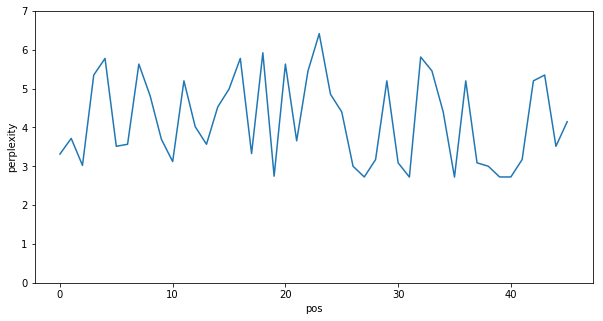

In [55]:
plot_perplexity_across_seq(reg_small_df)

In [26]:
regdb_pp_vec_df['seq_name'].unique()

array(['|yaaA|Sigma24', '|yaaH|Sigma24', '|apaH|Sigma24', ...,
       '|ytjC|Sigma70', '|yjjY|Sigma70', '|yjtD|Sigma70'], dtype=object)

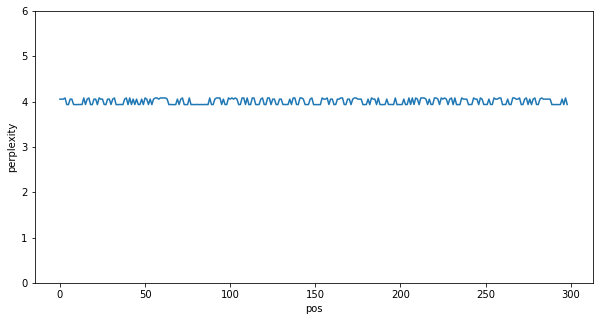

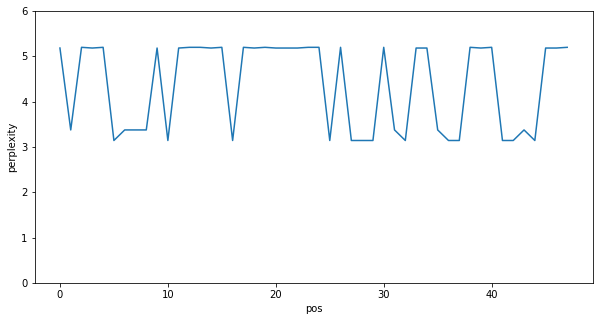

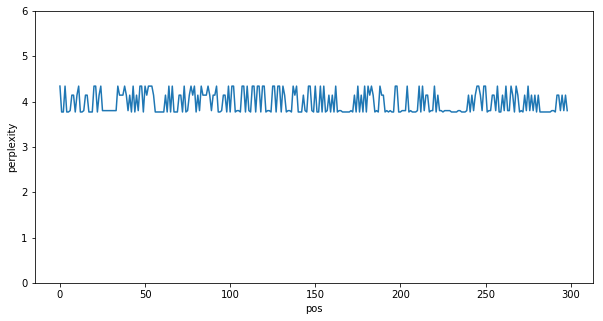

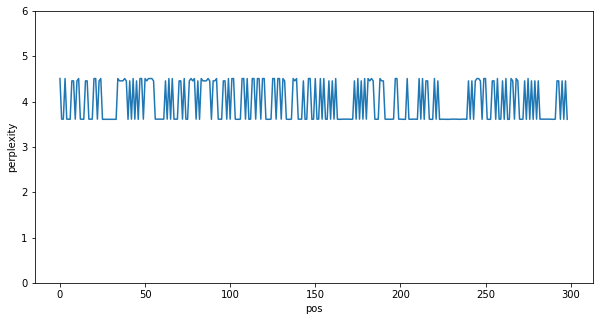

In [58]:
plot_perplexity_across_seq(rand_small_df)
plot_perplexity_across_seq(reg_small_df)
plot_perplexity_across_seq(naive_small_df)
plot_perplexity_across_seq(operon_small_df)

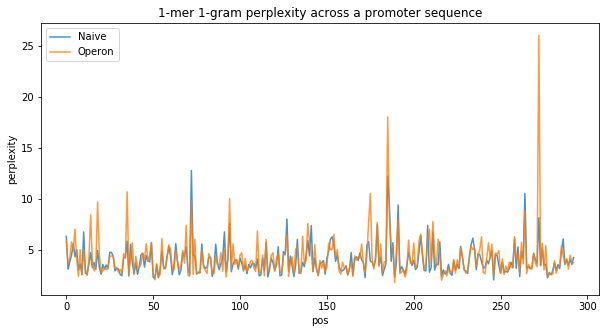

In [76]:
plot_naive_vs_operon_pp(naive_small_df, operon_small_df, 1,1)

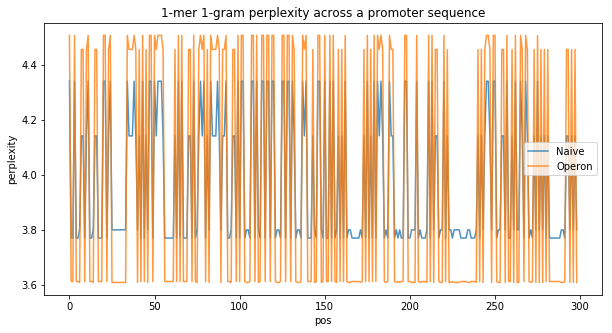

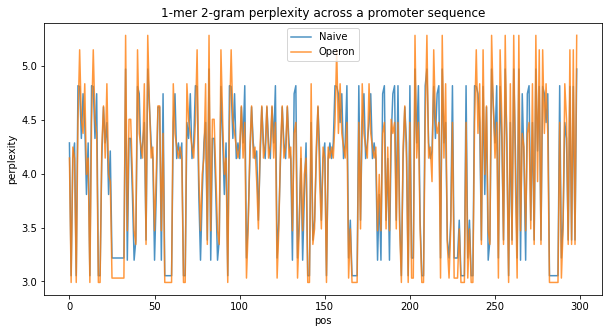

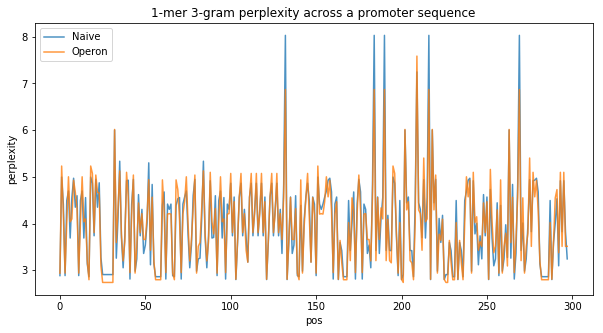

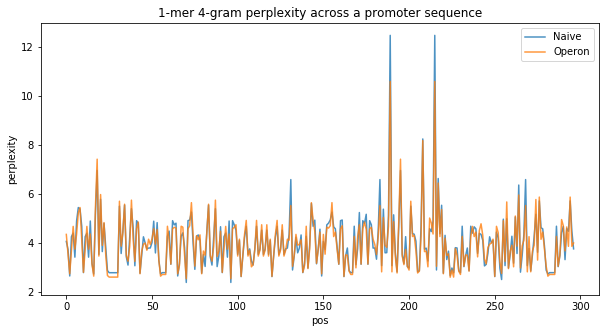

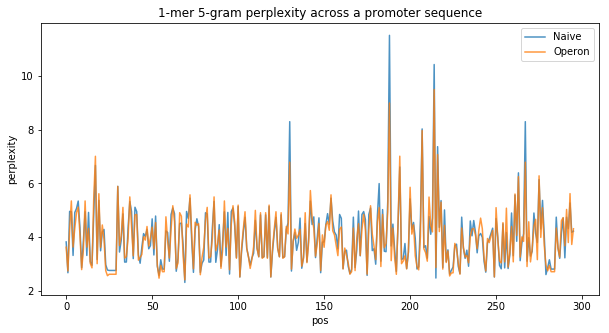

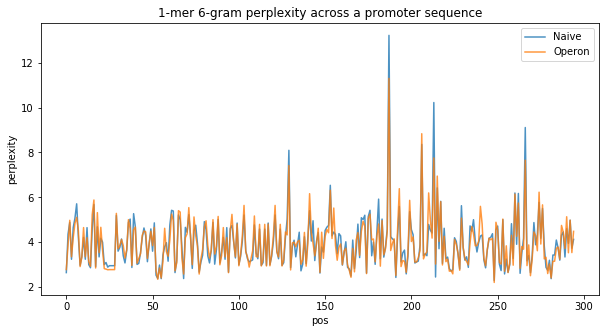

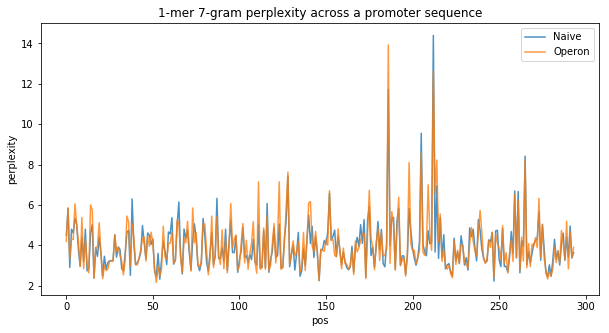

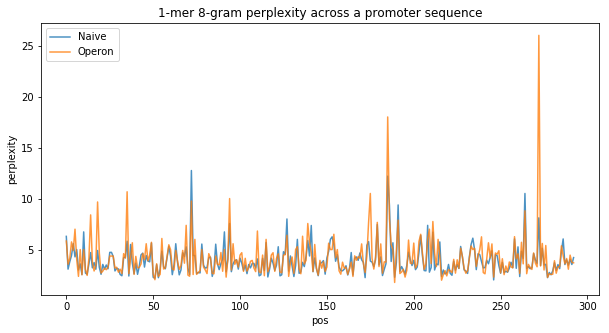

In [77]:
def compare_naive_vs_operon_pp(seq_name, k, n):
    
    naive_seq_df = naive_pp_vec_df.loc[(naive_pp_vec_df['seq_name'] == seq_name) & 
                                   (naive_pp_vec_df['k'] == k) &
                                   (naive_pp_vec_df['n'] == n)]

    operon_seq_df = operon_pp_vec_df.loc[(operon_pp_vec_df['seq_name'] == seq_name) & 
                                   (operon_pp_vec_df['k'] == k) &
                                   (operon_pp_vec_df['n'] == n)]

    plot_naive_vs_operon_pp(naive_seq_df, operon_seq_df, k, n)


compare_naive_vs_operon_pp('b0002|thrA', 1, 1)
compare_naive_vs_operon_pp('b0002|thrA', 1, 2)
compare_naive_vs_operon_pp('b0002|thrA', 1, 3)
compare_naive_vs_operon_pp('b0002|thrA', 1, 4)
compare_naive_vs_operon_pp('b0002|thrA', 1, 5)
compare_naive_vs_operon_pp('b0002|thrA', 1, 6)
compare_naive_vs_operon_pp('b0002|thrA', 1, 7)
compare_naive_vs_operon_pp('b0002|thrA', 1, 8)

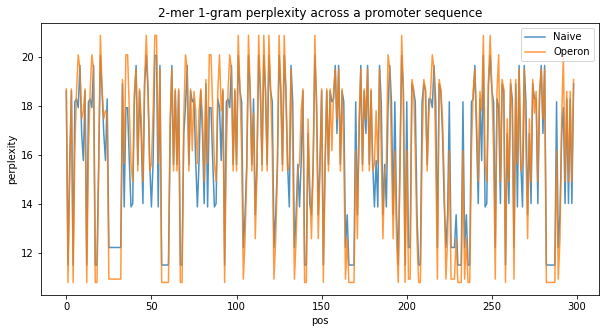

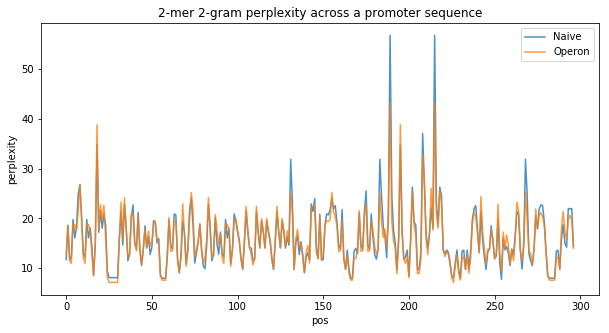

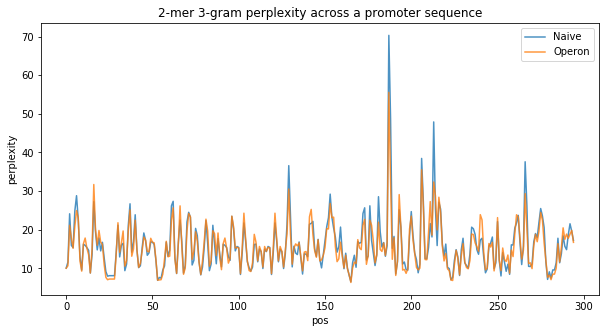

In [78]:
compare_naive_vs_operon_pp('b0002|thrA', 2, 1)
compare_naive_vs_operon_pp('b0002|thrA', 2, 2)
compare_naive_vs_operon_pp('b0002|thrA', 2, 3)


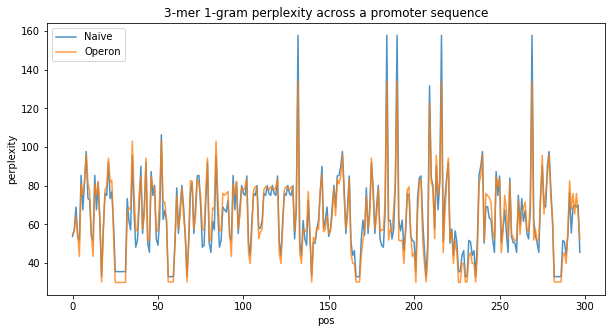

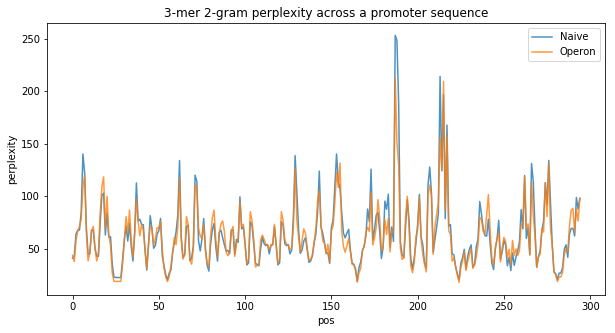

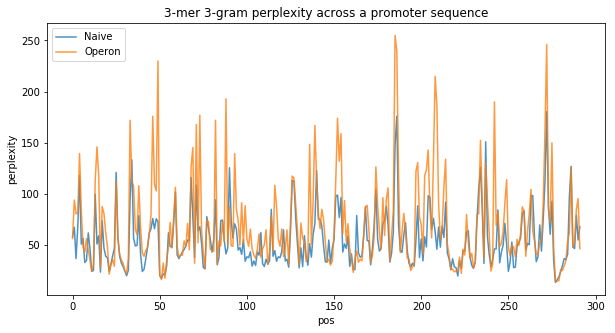

In [79]:
compare_naive_vs_operon_pp('b0002|thrA', 3, 1)
compare_naive_vs_operon_pp('b0002|thrA', 3, 2)
compare_naive_vs_operon_pp('b0002|thrA', 3, 3)

And this is about as far as I got for my NLP project! 

Still needs work:
* debugging add K smoothing implementation
* visualizing perplexity across a sequence

Check out the report for more narration/interpretation about the results! :) 